# Part B

## Defining functions for OLS and finding best MSE

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def runge_function(x):
    return 1/ (1 + 25 * x**2)

def runge_noisy(x, noise = 0.1):
    return runge_function(x) + np.random.normal(0, noise, size = x.shape)


def design_matrix_ols(x, degree):
    X = np.ones((x.shape[0], 1))
    for d in range(1, degree+1):
        X = np.hstack((X, x**d))
    return X

def ols_fit(X, y):
    beta = np.linalg.pinv(X.T @ X) @ X.T @ y
    return beta

def predict_ols(X, beta):
    return X @ beta

def mse(y_true, y_pred):
    n = y_true.shape[0]
    return 0.5 * np.sum((y_pred - y_true)**2) / n



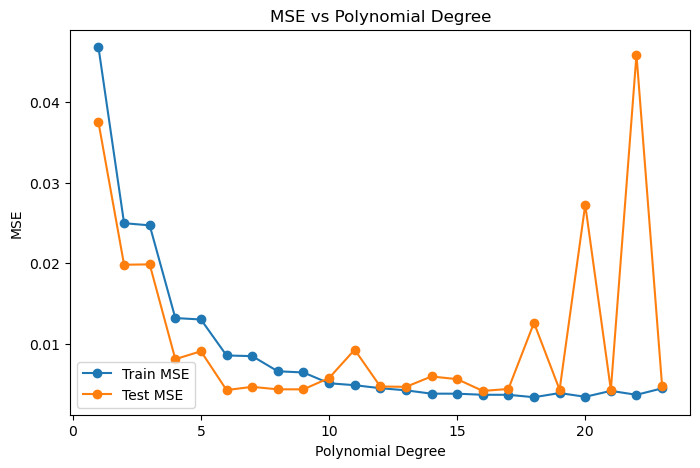

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
n_points = 100
x = np.linspace(-1, 1, n_points).reshape(-1, 1)

y_true = runge_function(x).ravel()

y = runge_noisy(x, noise = 0.1).ravel()
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Loop over polynomial degrees
degrees = range(1, 24)
mse_train, mse_test = [], []

for d in degrees:
    X_train = design_matrix_ols(x_train_scaled, d)
    X_test = design_matrix_ols(x_test_scaled, d)
    
    beta = ols_fit(X_train, y_train)
    
    y_train_pred = predict_ols(X_train, beta)
    y_test_pred = predict_ols(X_test, beta)
    
    mse_train.append(mse(y_train, y_train_pred))
    mse_test.append(mse(y_test, y_test_pred))

# Plot MSE only
plt.figure(figsize=(8, 5))
plt.plot(degrees, mse_train, 'o-', label="Train MSE")
plt.plot(degrees, mse_test, 'o-', label="Test MSE")
plt.xlabel("Polynomial Degree")
plt.ylabel("MSE")
plt.legend()
plt.title("MSE vs Polynomial Degree")
plt.show()


We first find the best Polynomial Degree using the standard OLS method, and we find that the best MSE happens when the Polynomial Degree is 9. We will now compare this to Stochastic Gradient Descent with adam, which we derived from project 1 to have the best MSE score for gradient descent methods. 

In [5]:
import numpy as np
import math

def adam_ols_minibatch_v2(
    X, y,
    alpha=1e-2,           
    beta1=0.9, beta2=0.999, eps=1e-8,
    batch_size=32,
    epochs=50,
    grad_tol=1e-8,
    theta0=None,
    weight_decay=0.0,    
    seed=None
):
    n, p = X.shape
    rng = np.random.default_rng(seed)
    theta = np.zeros(p) if theta0 is None else theta0.copy()
    m = np.zeros_like(theta)
    v = np.zeros_like(theta)
    t = 0

    history = {"loss": [], "grad_norm": []}
    steps_per_epoch = math.ceil(n / max(1, batch_size))

    for _ in range(epochs):
        perm = rng.permutation(n) #shuffle once per epoch

        for s in range(steps_per_epoch):
            start = s * batch_size
            end   = min((s + 1) * batch_size, n)
            idx   = perm[start:end]

            Xb, yb = X[idx], y[idx]
            rb   = Xb @ theta - yb
            grad = (2.0 / len(idx)) * (Xb.T @ rb)

            if weight_decay:
                theta *= (1 - alpha * weight_decay)

            t += 1
            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * (grad * grad)
            mhat = m / (1 - beta1**t)
            vhat = v / (1 - beta2**t)
            theta -= alpha * mhat / (np.sqrt(vhat) + eps)

        r_full = X @ theta - y
        loss_full = (r_full @ r_full) / n
        grad_full = (2.0 / n) * (X.T @ r_full)
        gnorm = np.linalg.norm(grad_full)
        history["loss"].append(loss_full)
        history["grad_norm"].append(gnorm)
        if gnorm <= grad_tol:
            break

    return theta, history



In [6]:
X_train = design_matrix_ols(x_train_scaled, 9)
X_test = design_matrix_ols(x_test_scaled, 9)
    
beta = ols_fit(X_train, y_train)
    
y_train_pred = predict_ols(X_train, beta)
y_test_pred = predict_ols(X_test, beta)
test_mse = mse(y_test_pred, y_test)
print(f"Test MSE for OLS: {test_mse:.4f}")
    
theta0  = np.zeros(X_train.shape[1]) 

beta, _ = adam_ols_minibatch_v2(X_train, y_train, theta0)
ytr_hat = predict_ols(X_train, beta)
yte_hat = predict_ols(X_test,  beta)
test_mse = mse(y_test, yte_hat)
print(f"Test MSE for Stochastic Gradient Descent with ADAM: {test_mse:.4f}")

Test MSE for OLS: 0.0043
Test MSE for Stochastic Gradient Descent with ADAM: 0.0677


We get the best Test MSE with standard OLS and we will use this for comparison

## Building The Neural Network Function

In [7]:
import numpy as np  
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


# Defining some activation functions and cost functons
def ReLU(z):
    return np.where(z > 0, z, 0)


def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_der(z):
    s = sigmoid(z)
    return s * (1 - s)

def ReLU_der(z):
    return np.where(z > 0, 1, 0)
    
def mse(y_true, y_pred):
    n = y_true.shape[0]
    return 0.5 * np.sum((y_pred - y_true)**2) / n

def mse_der_batch(y, t):
    return (1.0 / y.shape[0]) * (y - t)

def leaky_ReLU(z, alpha=0.01):
    """Leaky ReLU activation function"""
    return np.where(z > 0, z, alpha * z)

def leaky_ReLU_der(z, alpha=0.01):
    """Derivative of Leaky ReLU"""
    return np.where(z > 0, 1, alpha)



In [8]:
def create_layers_batch(network_input_size, layer_output_sizes):
    layers = []

    i_size = network_input_size
    for layer_output_size in layer_output_sizes:
        W = np.random.randn(layer_output_size, i_size)
        b = np.full((layer_output_size, 1), 0.01)
        layers.append((W, b))

        i_size = layer_output_size
    return layers


def feed_forward_batch(inputs, layers, activation_funcs):
    a = inputs
    for (W, b), activation_func in zip(layers, activation_funcs):
        z = W @ a.T + b
        a = activation_func(z).T
    return a

def feed_forward_saver_batch(inputs, layers, activation_funcs):
    layer_inputs = []   
    zs = []             
    a = inputs

    for (W, b), activation_func in zip(layers, activation_funcs):
        layer_inputs.append(a)
        z = W @ a.T + b                  
        a = activation_func(z).T        
        zs.append(z)
    return layer_inputs, zs, a

def backpropagation_batch(
    inputs, layers, activation_funcs, targets, activation_ders, cost_der=mse_der_batch
):
    N = inputs.shape[0]
    layer_inputs, zs, predict = feed_forward_saver_batch(inputs, layers, activation_funcs)

    layer_grads = [None] * len(layers)
    dC_dz_next = None  

    for i in reversed(range(len(layers))):
        layer_input = layer_inputs[i]      
        z = zs[i]                        
        activation_der = activation_ders[i]

        if i == len(layers) - 1:
            dC_da = cost_der(predict, targets)               
        else:
            W_next, _ = layers[i + 1]                        
            dC_da = dC_dz_next @ W_next                      

        dC_dz = dC_da * activation_der(z).T                  

     
        dC_dW = dC_dz.T @ layer_input                    
        dC_db = np.sum(dC_dz.T, axis=1, keepdims=True)   

        layer_grads[i] = (dC_dW, dC_db)

        dC_dz_next = dC_dz                                

    return layer_grads

def train_network_sgd_momentum(
    inputs, targets, layers, activation_funcs, activation_ders,
    lr=0.05, momentum=0.9, epochs=300, verbose_every=25, loss_func=None
):
    if loss_func is None:
        loss_func = mse
    
    velocities = [(np.zeros_like(W), np.zeros_like(b)) for (W, b) in layers]
    loss_hist = []
    
    for ep in range(epochs):
        # forward
        preds = feed_forward_batch(inputs, layers, activation_funcs)
        loss = loss_func(preds, targets)
        loss_hist.append(loss)
        
        grads = backpropagation_batch(inputs, layers, activation_funcs, targets, activation_ders)
        new_layers = []
        for (W, b), (dW, db), (vW, vb) in zip(layers, grads, velocities):
            vW = momentum * vW - lr * dW
            vb = momentum * vb - lr * db
            W  = W + vW
            b  = b + vb
            new_layers.append((W, b))
            # write back velocities
            velocities[len(new_layers)-1] = (vW, vb)
        layers = new_layers
        
        if verbose_every and (ep % verbose_every == 0 or ep == epochs-1):
            print(f"epoch {ep:4d} | loss {loss:.4f}")
    
    return layers, loss_hist


def train_network_gd(
    inputs, targets, layers, activation_funcs, activation_ders,
    lr=0.05, epochs=300, verbose_every=25, loss_func=None
):
    if loss_func is None:
        loss_func = mse
    
    loss_hist = []
    
    for ep in range(epochs):
        preds = feed_forward_batch(inputs, layers, activation_funcs)
        loss = loss_func(preds, targets)
        loss_hist.append(loss)
        
        grads = backpropagation_batch(inputs, layers, activation_funcs, targets, activation_ders)
        
        new_layers = []
        for (W, b), (dW, db) in zip(layers, grads):
            W = W - lr * dW
            b = b - lr * db
            new_layers.append((W, b))
        layers = new_layers
        
        if verbose_every and (ep % verbose_every == 0 or ep == epochs-1):
            print(f"epoch {ep:4d} | loss {loss:.4f}")
    
    return layers, loss_hist


def train_network_sgd_rmsprop(
    inputs, targets, layers, activation_funcs, activation_ders,
    lr=0.001, decay_rate=0.9, eps=1e-8, epochs=300, verbose_every=25, loss_func=None
):
    if loss_func is None:
        loss_func = mse
    
    cache = [(np.zeros_like(W), np.zeros_like(b)) for (W, b) in layers]
    loss_hist = []
    
    for ep in range(epochs):
        # forward
        preds = feed_forward_batch(inputs, layers, activation_funcs)
        loss = loss_func(preds, targets)
        loss_hist.append(loss)
        

        grads = backpropagation_batch(inputs, layers, activation_funcs, targets, activation_ders)
        
        new_layers = []
        for (W, b), (dW, db), (cW, cb) in zip(layers, grads, cache):
            cW = decay_rate * cW + (1 - decay_rate) * (dW ** 2)
            cb = decay_rate * cb + (1 - decay_rate) * (db ** 2)
            
            W = W - lr * dW / (np.sqrt(cW) + eps)
            b = b - lr * db / (np.sqrt(cb) + eps)
            
            new_layers.append((W, b))
            cache[len(new_layers)-1] = (cW, cb)
        layers = new_layers
        
        if verbose_every and (ep % verbose_every == 0 or ep == epochs-1):
            print(f"epoch {ep:4d} | loss {loss:.4f}")
    
    return layers, loss_hist


def train_network_sgd_adam(
    inputs, targets, layers, activation_funcs, activation_ders,
    lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8, epochs=300, verbose_every=25, loss_func=None
):
    if loss_func is None:
        loss_func = mse
    
    # Initialize first and second moment estimates
    m = [(np.zeros_like(W), np.zeros_like(b)) for (W, b) in layers]
    v = [(np.zeros_like(W), np.zeros_like(b)) for (W, b) in layers]
    loss_hist = []
    
    for ep in range(epochs):
        # forward
        preds = feed_forward_batch(inputs, layers, activation_funcs)
        loss = loss_func(preds, targets)
        loss_hist.append(loss)
        
        # backward
        grads = backpropagation_batch(inputs, layers, activation_funcs, targets, activation_ders)
        
        # Adam update
        new_layers = []
        t = ep + 1
        
        for i, ((W, b), (dW, db), (mW, mb), (vW, vb)) in enumerate(zip(layers, grads, m, v)):
     
            mW = beta1 * mW + (1 - beta1) * dW
            mb = beta1 * mb + (1 - beta1) * db
            
           
            vW = beta2 * vW + (1 - beta2) * (dW ** 2)
            vb = beta2 * vb + (1 - beta2) * (db ** 2)
            
        
            mW_hat = mW / (1 - beta1 ** t)
            mb_hat = mb / (1 - beta1 ** t)
            vW_hat = vW / (1 - beta2 ** t)
            vb_hat = vb / (1 - beta2 ** t)
            
      
            W = W - lr * mW_hat / (np.sqrt(vW_hat) + eps)
            b = b - lr * mb_hat / (np.sqrt(vb_hat) + eps)
            
            new_layers.append((W, b))
     
            m[i] = (mW, mb)
            v[i] = (vW, vb)
        layers = new_layers
        
        if verbose_every and (ep % verbose_every == 0 or ep == epochs-1):
            print(f"epoch {ep:4d} | loss {loss:.4f}")
    
    return layers, loss_hist

## Testing of Functions and Comparison ( DONT RUN THIS FUNCTION AGAIN PLEASE )

In [115]:
np.random.seed(42)

X_train = design_matrix_ols(x_train_scaled, 9)
X_test = design_matrix_ols(x_test_scaled, 9)
    
beta = ols_fit(X_train, y_train)
    
y_train_pred = predict_ols(X_train, beta)
y_test_pred = predict_ols(X_test, beta)
test_mse_ols = mse(y_test_pred, y_test)


x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
targets = y_train.reshape(-1, 1)
inputs = x_train_scaled
network_input_size = 1


layer_output_sizes = [50, 1]
activation_funcs = [sigmoid, sigmoid]
activation_ders = [sigmoid_der, sigmoid_der]
layers = create_layers_batch(network_input_size, layer_output_sizes)
layers = create_layers_batch(network_input_size, layer_output_sizes)
layers,loss_hist = train_network_sgd_adam(
    inputs, targets, layers, activation_funcs, activation_ders,
    lr=0.001, beta1=0.9, beta2=0.999, epochs=500, verbose_every=50
)
y_pred_test = feed_forward_batch(x_test_scaled, layers, activation_funcs)
test_mse = mse(y_test.reshape(-1, 1), y_pred_test)


layer_output_sizes = [50, 100, 1]
activation_funcs = [sigmoid, sigmoid, sigmoid]
activation_ders = [sigmoid_der, sigmoid_der, sigmoid_der]
layers = create_layers_batch(network_input_size, layer_output_sizes)
layers = create_layers_batch(network_input_size, layer_output_sizes)
layers,loss_hist = train_network_sgd_adam(
    inputs, targets, layers, activation_funcs, activation_ders,
    lr=0.001, beta1=0.9, beta2=0.999, epochs=500, verbose_every=50
)

y_pred_test = feed_forward_batch(x_test_scaled, layers, activation_funcs)
test_mse = mse(y_test.reshape(-1, 1), y_pred_test)
print(f"\nTest MSE for Neural Network with one hidden layer: {test_mse:.4f}")
print(f"\nTest MSE for Neural Network with two hidden layers: {test_mse:.4f}")
print(f"Test MSE for OLS: {test_mse_ols:.4f}")

epoch    0 | loss 0.2405
epoch   50 | loss 0.1065
epoch  100 | loss 0.0527
epoch  150 | loss 0.0498
epoch  200 | loss 0.0487
epoch  250 | loss 0.0475
epoch  300 | loss 0.0463
epoch  350 | loss 0.0451
epoch  400 | loss 0.0438
epoch  450 | loss 0.0426
epoch  499 | loss 0.0413
epoch    0 | loss 0.1434
epoch   50 | loss 0.0225
epoch  100 | loss 0.0115
epoch  150 | loss 0.0091
epoch  200 | loss 0.0081
epoch  250 | loss 0.0074
epoch  300 | loss 0.0069
epoch  350 | loss 0.0066
epoch  400 | loss 0.0063
epoch  450 | loss 0.0060
epoch  499 | loss 0.0058

Test MSE for Neural Network with one hidden layer: 0.0032

Test MSE for Neural Network with two hidden layers: 0.0032
Test MSE for OLS: 0.0043


reminder for myself for methodology:
Bias : we initialise bias to a small constant 0.01. We do not need to initialise it randomly since it does not create any symmetrical issues that we would have if the weights were not randomly initiialsed.
Activation functions : Looking at the runge function, the range of values (0,1) means that the sigmoid function and the ReLU function would both work. Although sigmoid is primarily for binary classification, it would work in this scenario, and we will use sigmoid as the activation function
Design Matrix: since the neural network is able to learn complex features that linear regression is unable to, we don't need to create a design matrix with different polynomial degrees, and the neural network will be able to learn these complexities with just the input being x.

Discussion of Results: 

We are able to achieve better Test MSE with neural network as compared to ols. The runge function is not a polynomial and it has sharp peaks and variations that is difficult to approximate with polynomials, thus limiting the effectiveness of ols. With a nerural network, we are able to learn these complexitie and the network creates non-linear feature combinations that are able to approximate the rungefunction better than linear regression. 


## Extending to the 2 Dimensional Runge Function


Training samples: 280
Test samples: 120
Input features: 2
epoch    0 | loss 0.3148
epoch   50 | loss 0.0129
epoch  100 | loss 0.0128
epoch  150 | loss 0.0122
epoch  200 | loss 0.0109
epoch  250 | loss 0.0070
epoch  300 | loss 0.0037
epoch  350 | loss 0.0023
epoch  400 | loss 0.0016
epoch  450 | loss 0.0012
epoch  499 | loss 0.0009

Train MSE: 0.000927
Test MSE: 0.001362


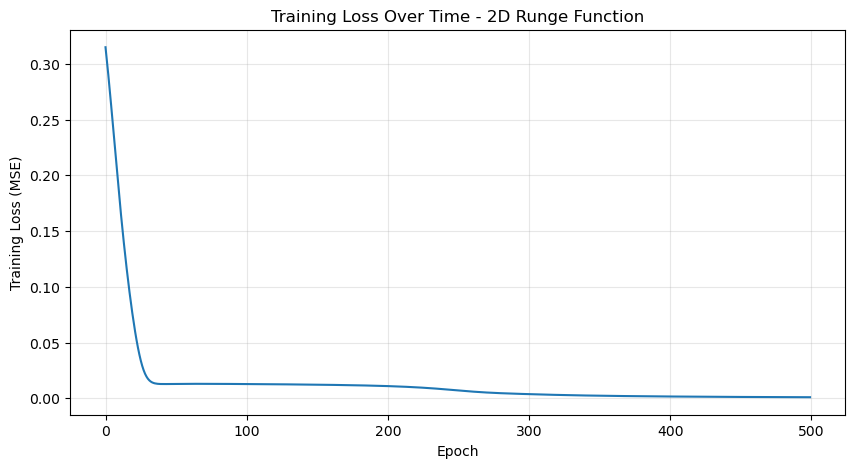

In [9]:
def runge_function_2d(x, y):
    return 1 / ((10*x - 5)**2 + (10*y - 5)**2 + 1)

np.random.seed(42)
n_points = 20 
x_1d = np.linspace(0, 1, n_points)
y_1d = np.linspace(0, 1, n_points)
x_mesh, y_mesh = np.meshgrid(x_1d, y_1d)

x_flat = x_mesh.ravel()
y_flat = y_mesh.ravel()
X = np.column_stack([x_flat, y_flat]) 


z_true = runge_function_2d(x_flat, y_flat)

X_train, X_test, z_train, z_test = train_test_split(
    X, z_true, test_size=0.3, random_state=42
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)        

print(f"Training samples: {X_train_scaled.shape[0]}")
print(f"Test samples: {X_test_scaled.shape[0]}")
print(f"Input features: {X_train_scaled.shape[1]}")


targets = z_train.reshape(-1, 1)
inputs = X_train_scaled

network_input_size = 2  
layer_output_sizes = [50,100, 1]
activation_funcs = [sigmoid, sigmoid, sigmoid]
activation_ders = [sigmoid_der, sigmoid_der, sigmoid_der]


layers = create_layers_batch(network_input_size, layer_output_sizes)
layers, loss_hist = train_network_sgd_adam(
    inputs, targets, layers, activation_funcs, activation_ders,
    lr=0.001, beta1=0.9, beta2=0.999, epochs=500, verbose_every=50
)


z_pred_test = feed_forward_batch(X_test_scaled, layers, activation_funcs)
test_mse = mse(z_test.reshape(-1, 1), z_pred_test)

z_pred_train = feed_forward_batch(X_train_scaled, layers, activation_funcs)
train_mse = mse(z_train.reshape(-1, 1), z_pred_train)

print(f"\nTrain MSE: {train_mse:.6f}")
print(f"Test MSE: {test_mse:.6f}")




plt.figure(figsize=(10, 5))
plt.plot(loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Training Loss (MSE)')
plt.title('Training Loss Over Time - 2D Runge Function')
plt.grid(True, alpha=0.3)
plt.show()

To extend to the 2-dimensional Runge function, we perform the same procedure as the 1D case with three key changes: (1) network input size increases from 1 to 2, (2) input data becomes X of shape (n, 2) containing [x, y] pairs instead of just x values, and (3) outputs are z = f(x, y) instead of y = f(x). For data generation, we create 20 sample points for both x and y in [0, 1], then use meshgrid() to form all possible combinations, yielding 20×20 = 400 total sample points. The network architecture, training procedure, and evaluation remain identical to the 1D case.

We observe that the Training loss decreases steadily across the epochs, and our Test MSE is very similar to our training MSE, showing that the model captures the function structure well and did not overfit

Any future evaluation will be done using the 2D runge function

## Testing across different learning rates


Testing Plain GD:
  lr=0.0010 | Train: 0.215351 | Test: 0.210547
  lr=0.0100 | Train: 0.013928 | Test: 0.014359
  lr=0.0500 | Train: 0.012035 | Test: 0.011369
  lr=0.1000 | Train: 0.009575 | Test: 0.009119
  lr=0.5000 | Train: 0.001804 | Test: 0.002230
  Best lr for Plain GD: 0.5000 (Test MSE: 0.002230)

Testing SGD Momentum:
  lr=0.0010 | Train: 0.013989 | Test: 0.014390
  lr=0.0100 | Train: 0.013115 | Test: 0.012234
  lr=0.0500 | Train: 0.014126 | Test: 0.012929
  lr=0.1000 | Train: 0.014129 | Test: 0.012932
  lr=0.5000 | Train: 0.014129 | Test: 0.012932
  Best lr for SGD Momentum: 0.0100 (Test MSE: 0.012234)

Testing RMSprop:
  lr=0.0001 | Train: 0.006648 | Test: 0.005982
  lr=0.0010 | Train: 0.000347 | Test: 0.000582
  lr=0.0100 | Train: 0.000984 | Test: 0.001137
  lr=0.1000 | Train: 0.014129 | Test: 0.012932
  Best lr for RMSprop: 0.0010 (Test MSE: 0.000582)

Testing Adam:
  lr=0.0001 | Train: 0.011409 | Test: 0.011216
  lr=0.0010 | Train: 0.000927 | Test: 0.001362
  lr=0.0100 | 

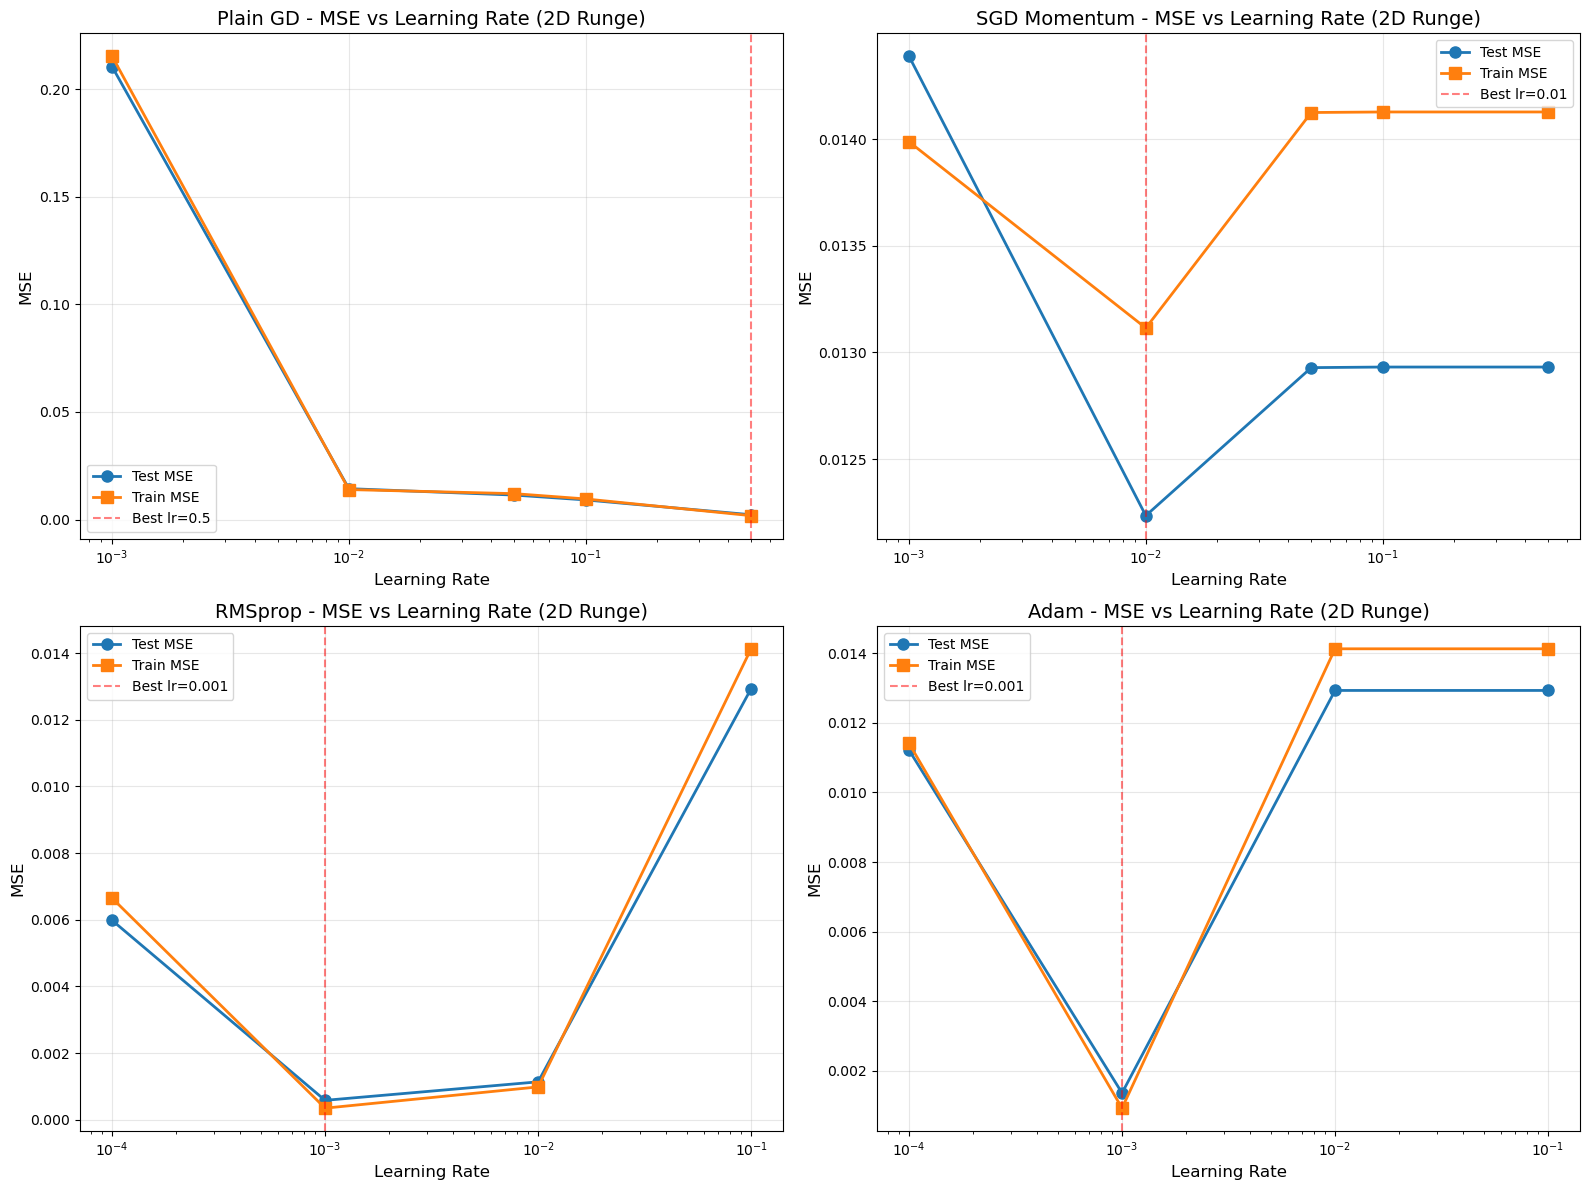


SUMMARY: Best Learning Rate for Each Optimizer (2D Runge Function)
Optimizer            Best LR         Test MSE        Train MSE      
Plain GD             0.5000          0.002230        0.001804       
SGD Momentum         0.0100          0.012234        0.013115       
RMSprop              0.0010          0.000582        0.000347       
Adam                 0.0010          0.001362        0.000927       

Overall Best: RMSprop with lr=0.0010, Test MSE=0.000582


<Figure size 640x480 with 0 Axes>

In [130]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)


inputs = X_train_scaled  
targets = z_train.reshape(-1, 1) 
network_input_size = 2  
layer_output_sizes = [50, 100, 1]
activation_funcs = [sigmoid, sigmoid, sigmoid]
activation_ders = [sigmoid_der, sigmoid_der, sigmoid_der]

optimizer_configs = {
    'Plain GD': {
        'function': train_network_gd,
        'learning_rates': [0.001, 0.01, 0.05, 0.1, 0.5],
        'params': {}
    },
    'SGD Momentum': {
        'function': train_network_sgd_momentum,
        'learning_rates': [0.001, 0.01, 0.05, 0.1, 0.5],
        'params': {'momentum': 0.9}
    },
    'RMSprop': {
        'function': train_network_sgd_rmsprop,
        'learning_rates': [0.0001, 0.001, 0.01, 0.1],
        'params': {'decay_rate': 0.9}
    },
    'Adam': {
        'function': train_network_sgd_adam,
        'learning_rates': [0.0001, 0.001, 0.01, 0.1],
        'params': {'beta1': 0.9, 'beta2': 0.999}
    }
}

all_results = {}


for opt_name, config in optimizer_configs.items():
    print(f"\nTesting {opt_name}:")
    print("=" * 60)
    
    opt_results = {}
    
    for lr in config['learning_rates']:
        np.random.seed(42)
        layers = create_layers_batch(network_input_size, layer_output_sizes)
        

        layers, loss_hist = config['function'](
            inputs, targets, layers, activation_funcs, activation_ders,
            lr=lr, epochs=500, verbose_every=None, **config['params']
        )
        
    
        z_pred_test = feed_forward_batch(X_test_scaled, layers, activation_funcs)  # Changed variable names
        test_mse = mse(z_test.reshape(-1, 1), z_pred_test)  # Changed from y_test
        
     
        z_pred_train = feed_forward_batch(X_train_scaled, layers, activation_funcs)  # Changed variable names
        train_mse = mse(z_train.reshape(-1, 1), z_pred_train)  # Changed from y_train
        
        opt_results[lr] = {
            'test_mse': test_mse,
            'train_mse': train_mse,
            'loss_hist': loss_hist
        }
        
        print(f"  lr={lr:.4f} | Train: {train_mse:.6f} | Test: {test_mse:.6f}")
    

    best_lr = min(opt_results.keys(), key=lambda lr: opt_results[lr]['test_mse'])
    print(f"  Best lr for {opt_name}: {best_lr:.4f} (Test MSE: {opt_results[best_lr]['test_mse']:.6f})")
    
    all_results[opt_name] = opt_results


fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, (opt_name, opt_results) in enumerate(all_results.items()):
    ax = axes[idx]
    
    lrs = list(opt_results.keys())
    test_mses = [opt_results[lr]['test_mse'] for lr in lrs]
    train_mses = [opt_results[lr]['train_mse'] for lr in lrs]
    
    best_lr = min(lrs, key=lambda lr: opt_results[lr]['test_mse'])
    
    ax.plot(lrs, test_mses, 'o-', label='Test MSE', linewidth=2, markersize=8)
    ax.plot(lrs, train_mses, 's-', label='Train MSE', linewidth=2, markersize=8)
    ax.axvline(best_lr, color='red', linestyle='--', alpha=0.5, label=f'Best lr={best_lr}')
    
    ax.set_xlabel('Learning Rate', fontsize=12)
    ax.set_ylabel('MSE', fontsize=12)
    ax.set_title(f'{opt_name} - MSE vs Learning Rate (2D Runge)', fontsize=14)
    ax.set_xscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final summary
print("\n" + "=" * 80)
print("SUMMARY: Best Learning Rate for Each Optimizer (2D Runge Function)")
print("=" * 80)
print(f"{'Optimizer':<20} {'Best LR':<15} {'Test MSE':<15} {'Train MSE':<15}")
print("=" * 80)

for opt_name, opt_results in all_results.items():
    best_lr = min(opt_results.keys(), key=lambda lr: opt_results[lr]['test_mse'])
    test_mse = opt_results[best_lr]['test_mse']
    train_mse = opt_results[best_lr]['train_mse']
    print(f"{opt_name:<20} {best_lr:<15.4f} {test_mse:<15.6f} {train_mse:<15.6f}")




best_overall = min(
    [(opt, lr, res['test_mse']) 
     for opt, opt_res in all_results.items() 
     for lr, res in opt_res.items()],
    key=lambda x: x[2]
)

print(f"\nOverall Best: {best_overall[0]} with lr={best_overall[1]:.4f}, Test MSE={best_overall[2]:.6f}")





best_opt, best_lr_overall, _ = best_overall
best_layers = None

np.random.seed(42)
layers = create_layers_batch(network_input_size, layer_output_sizes)
layers, _ = optimizer_configs[best_opt]['function'](
    inputs, targets, layers, activation_funcs, activation_ders,
    lr=best_lr_overall, epochs=500, verbose_every=None,
    **optimizer_configs[best_opt]['params']
)



ax3 = fig.add_subplot(133, projection='3d')
error_mesh = np.abs(z_true_mesh - z_pred_mesh)
surf3 = ax3.plot_surface(x_mesh, y_mesh, error_mesh, cmap='Reds', alpha=0.8)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('|Error|')
ax3.set_title('Absolute Prediction Error')
fig.colorbar(surf3, ax=ax3, shrink=0.5)

plt.tight_layout()
plt.show()

Methodology:

For each optimizer (Plain Gradient Descent, SGD with Momentum, RMSprop, and Adam), we perform gradient descent with different learning rates. We test learning rates from 0.001 to 0.5 for Plain GD and Momentum, and 0.0001 to 0.1 for RMSprop and Adam, as adaptive optimizers typically require smaller rates. All models use the same network architecture [50, 100, 1] and are trained for 500 epochs with identical weight initialization (seed=42) to ensure fair comparison. We record the test MSE for each configuration and plot it against the learning rates to identify the optimal learning rate for each optimizer."

From the results, we find that the best learning rate for plain gradient descent is 0.5. 
SGD Momentum: 0.01
RMSprop: 0.001
Adam: 0.001, with RMSprop performing the best

# Part C ( DO NOT RUN THE CELLS IN THIS PART PLEASE )


Learning rate = 0.0001
----------------------------------------------------------------------
Train MSE: 0.017458
Test MSE: 0.016926

Learning rate = 0.001
----------------------------------------------------------------------
Train MSE: 0.017443
Test MSE: 0.016960

Learning rate = 0.01
----------------------------------------------------------------------
Train MSE: 0.000338
Test MSE: 0.000525

Learning rate = 0.1
----------------------------------------------------------------------
Train MSE: 0.028257
Test MSE: 0.025863

SUMMARY: Keras 2D Results (RMSprop)
Learning Rate   Train MSE       Test MSE       
0.0001          0.017458        0.016926       
0.0010          0.017443        0.016960       
0.0100          0.000338        0.000525       
0.1000          0.028257        0.025863       
Best Learning Rate: 0.0100
Best Test MSE: 0.000525


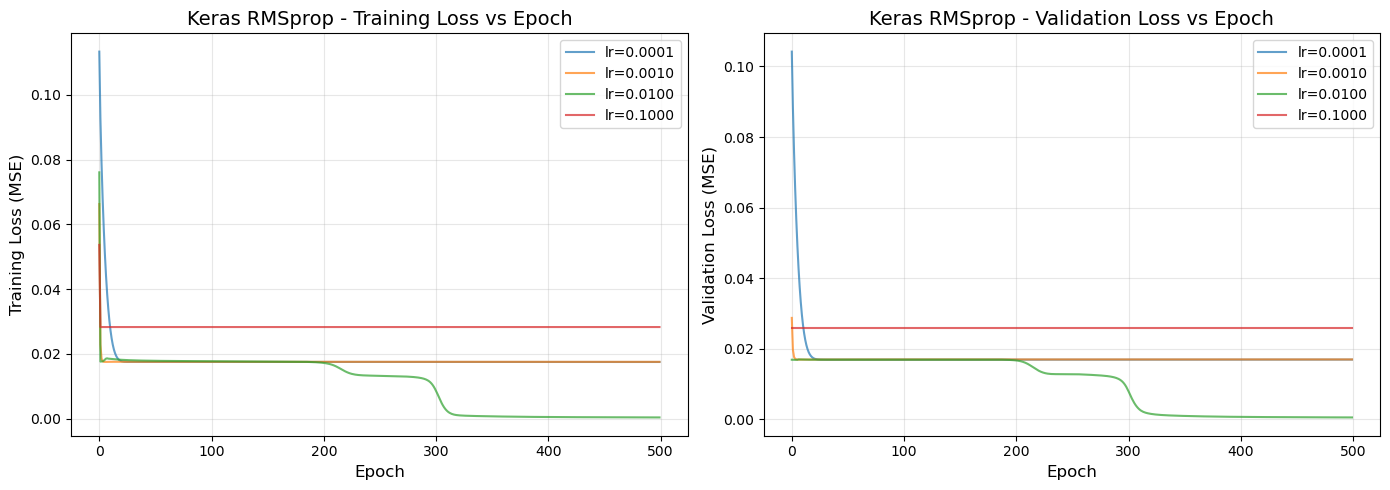

<Figure size 640x480 with 0 Axes>

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers, regularizers
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(42)
tf.random.set_seed(42)

epochs = 500
batch_size = 32
n_neurons_layer1 = 50
n_neurons_layer2 = 100
n_outputs = 1

eta_vals = np.array([0.0001, 0.001, 0.01, 0.1])
lmbd = 0.0 

def create_neural_network_keras_2d(n_neurons_layer1, n_neurons_layer2, n_outputs, eta, lmbd):
    model = Sequential()
    
    model.add(Dense(n_neurons_layer1, activation='sigmoid', 
                   kernel_regularizer=regularizers.l2(lmbd),
                   input_shape=(2,)))  

    model.add(Dense(n_neurons_layer2, activation='sigmoid', 
                   kernel_regularizer=regularizers.l2(lmbd)))
    
    model.add(Dense(n_outputs, activation='sigmoid'))
    

    rmsprop = optimizers.RMSprop(learning_rate=eta, rho=0.9)  
    
    model.compile(loss='mse', optimizer=rmsprop, metrics=['mse'])
    
    return model


X_train = X_train_scaled 
Y_train = z_train.reshape(-1, 1)  
X_test = X_test_scaled 
Y_test = z_test.reshape(-1, 1)  


results_keras_2d = {}



for eta in eta_vals:
    print(f"\nLearning rate = {eta}")
    print("-" * 70)
    

    np.random.seed(42)
    tf.random.set_seed(42)
    

    DNN = create_neural_network_keras_2d(n_neurons_layer1, n_neurons_layer2, n_outputs,
                                        eta=eta, lmbd=lmbd)
    

    history = DNN.fit(X_train, Y_train, 
                     epochs=epochs, 
                     batch_size=batch_size, 
                     verbose=0,
                     validation_data=(X_test, Y_test))
    
   
    test_loss, test_mse = DNN.evaluate(X_test, Y_test, verbose=0)
    
  
    train_loss, train_mse = DNN.evaluate(X_train, Y_train, verbose=0)
    

    results_keras_2d[eta] = {
        'model': DNN,
        'history': history,
        'train_mse': train_mse,
        'test_mse': test_mse
    }
    
    print(f"Train MSE: {train_mse:.6f}")
    print(f"Test MSE: {test_mse:.6f}")

print("\n" + "=" * 70)
print("SUMMARY: Keras 2D Results (RMSprop)")
print("=" * 70)
print(f"{'Learning Rate':<15} {'Train MSE':<15} {'Test MSE':<15}")
print("=" * 70)

for eta in eta_vals:
    train_mse = results_keras_2d[eta]['train_mse']
    test_mse = results_keras_2d[eta]['test_mse']
    print(f"{eta:<15.4f} {train_mse:<15.6f} {test_mse:<15.6f}")


best_eta_2d = min(results_keras_2d.keys(), key=lambda k: results_keras_2d[k]['test_mse'])
best_test_mse_2d = results_keras_2d[best_eta_2d]['test_mse']
print("=" * 70)
print(f"Best Learning Rate: {best_eta_2d:.4f}")
print(f"Best Test MSE: {best_test_mse_2d:.6f}")
print("=" * 70)


plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
for eta in eta_vals:
    history = results_keras_2d[eta]['history']
    plt.plot(history.history['loss'], label=f'lr={eta:.4f}', alpha=0.7)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss (MSE)', fontsize=12)
plt.title('Keras RMSprop - Training Loss vs Epoch', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
for eta in eta_vals:
    history = results_keras_2d[eta]['history']
    plt.plot(history.history['val_loss'], label=f'lr={eta:.4f}', alpha=0.7)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Validation Loss (MSE)', fontsize=12)
plt.title('Keras RMSprop - Validation Loss vs Epoch', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


ax3 = fig.add_subplot(133, projection='3d')
error_mesh = np.abs(runge_function_2d(x_mesh, y_mesh) - z_pred_keras)
ax3.plot_surface(x_mesh, y_mesh, error_mesh, cmap='Reds', alpha=0.8)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('|Error|')
ax3.set_title('Absolute Prediction Error')

plt.tight_layout()
plt.show()

Methodology: We test our network against the Tenserflow/Keras library, replicating the same network and training procedure. We construct a sequential model and add layers to the model similar to that of our network, setting the same optimiser, hidden layers as well as activation functions. Similarly to our network, we run the Tenserflow/Keras model with different learning rates and find the best learning rate

With the optimal learning rate of 0.01, the TensorFlow/Keras model achieves a test MSE of 0.000338, significantly outperforming our custom implementation. This improvement likely stems from better weight initialization – Keras uses Glorot/Xavier initialization that adapts to layer dimensions, whereas our implementation uses standard normal initialization with fixed variance




# PART D

## Testing against Activation Functions


All Sigmoid: Sigmoid → Sigmoid → Sigmoid
--------------------------------------------------------------------------------
Train MSE: 0.000984
Test MSE: 0.001137 ✓

All ReLU: ReLU → ReLU → ReLU
--------------------------------------------------------------------------------
Train MSE: 0.014129
Test MSE: 0.012932 ✓

All Leaky ReLU: Leaky ReLU → Leaky ReLU → Leaky ReLU
--------------------------------------------------------------------------------
Train MSE: 0.042253
Test MSE: 0.045329 ✓

ReLU-Sigmoid: ReLU → ReLU → Sigmoid (output)
--------------------------------------------------------------------------------
Train MSE: 0.009127
Test MSE: 0.007415 ✓

Leaky ReLU-Sigmoid: Leaky ReLU → Leaky ReLU → Sigmoid (output)
--------------------------------------------------------------------------------
Train MSE: 0.003375
Test MSE: 0.004711 ✓

Sigmoid-ReLU: Sigmoid → Sigmoid → ReLU (output)
--------------------------------------------------------------------------------
Train MSE: 0.014129
Test

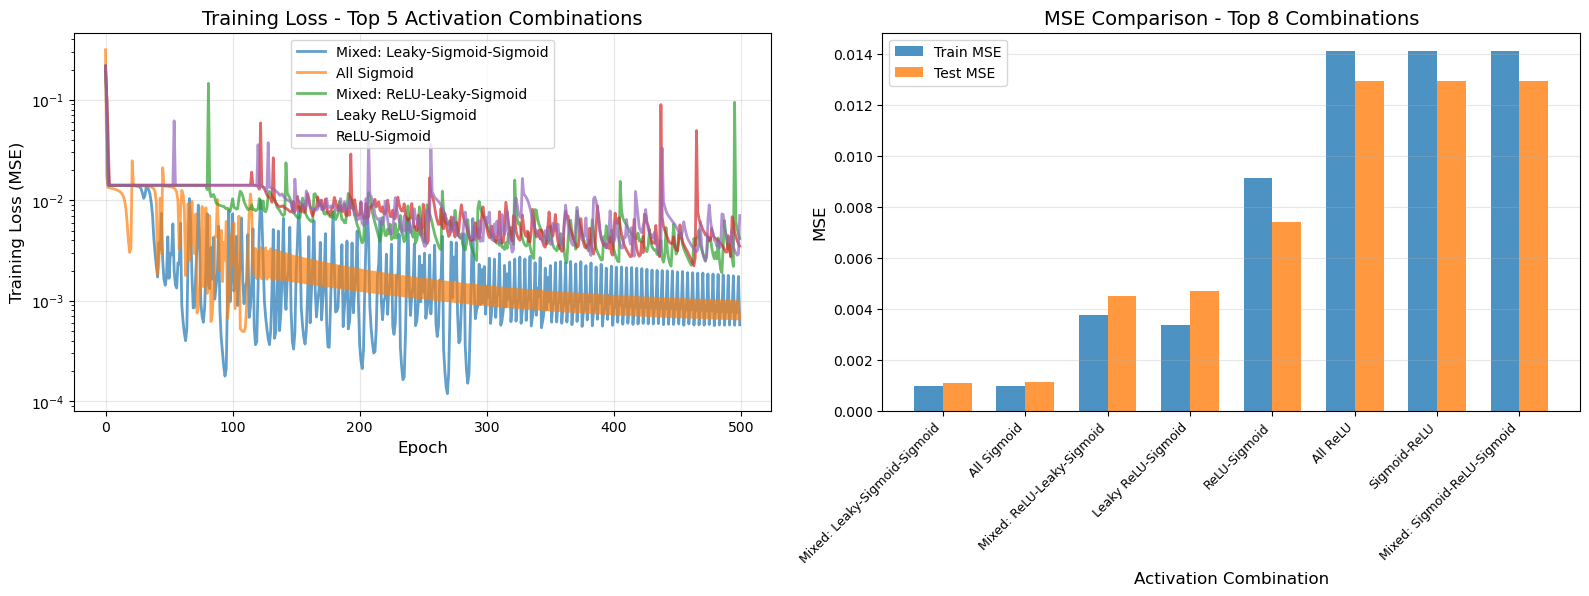

In [150]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)


targets = z_train.reshape(-1, 1)
inputs = X_train_scaled
network_input_size = 2  
layer_output_sizes = [50, 100, 1]

activation_combos = {
    'All Sigmoid': {
        'funcs': [sigmoid, sigmoid, sigmoid],
        'ders': [sigmoid_der, sigmoid_der, sigmoid_der],
        'description': 'Sigmoid → Sigmoid → Sigmoid'
    },
    'All ReLU': {
        'funcs': [ReLU, ReLU, ReLU],
        'ders': [ReLU_der, ReLU_der, ReLU_der],
        'description': 'ReLU → ReLU → ReLU'
    },
    'All Leaky ReLU': {
        'funcs': [leaky_ReLU, leaky_ReLU, leaky_ReLU],
        'ders': [leaky_ReLU_der, leaky_ReLU_der, leaky_ReLU_der],
        'description': 'Leaky ReLU → Leaky ReLU → Leaky ReLU'
    },
    'ReLU-Sigmoid': {
        'funcs': [ReLU, ReLU, sigmoid],
        'ders': [ReLU_der, ReLU_der, sigmoid_der],
        'description': 'ReLU → ReLU → Sigmoid (output)'
    },
    'Leaky ReLU-Sigmoid': {
        'funcs': [leaky_ReLU, leaky_ReLU, sigmoid],
        'ders': [leaky_ReLU_der, leaky_ReLU_der, sigmoid_der],
        'description': 'Leaky ReLU → Leaky ReLU → Sigmoid (output)'
    },
    'Sigmoid-ReLU': {
        'funcs': [sigmoid, sigmoid, ReLU],
        'ders': [sigmoid_der, sigmoid_der, ReLU_der],
        'description': 'Sigmoid → Sigmoid → ReLU (output)'
    },
    'Mixed: Sigmoid-ReLU-Sigmoid': {
        'funcs': [sigmoid, ReLU, sigmoid],
        'ders': [sigmoid_der, ReLU_der, sigmoid_der],
        'description': 'Sigmoid → ReLU → Sigmoid'
    },
    'Mixed: ReLU-Sigmoid-ReLU': {
        'funcs': [ReLU, sigmoid, ReLU],
        'ders': [ReLU_der, sigmoid_der, ReLU_der],
        'description': 'ReLU → Sigmoid → ReLU'
    },
    'Mixed: ReLU-Leaky-Sigmoid': {
        'funcs': [ReLU, leaky_ReLU, sigmoid],
        'ders': [ReLU_der, leaky_ReLU_der, sigmoid_der],
        'description': 'ReLU → Leaky ReLU → Sigmoid'
    },
    'Mixed: Leaky-Sigmoid-Sigmoid': {
        'funcs': [leaky_ReLU, sigmoid, sigmoid],
        'ders': [leaky_ReLU_der, sigmoid_der, sigmoid_der],
        'description': 'Leaky ReLU → Sigmoid → Sigmoid'
    }
}


results_combos = {}


for combo_name, config in activation_combos.items():
    print(f"\n{combo_name}: {config['description']}")
    print("-" * 80)

    np.random.seed(42)

    layers = create_layers_batch(network_input_size, layer_output_sizes)
    

    try:
        layers, loss_hist = train_network_sgd_rmsprop(
            inputs, targets, layers, 
            config['funcs'], config['ders'],
            lr=0.01, decay_rate=0.9, eps=1e-8, 
            epochs=500, verbose_every=None
        )
        
  
        z_pred_test = feed_forward_batch(X_test_scaled, layers, config['funcs'])
        test_mse = mse(z_test.reshape(-1, 1), z_pred_test)
        
       
        z_pred_train = feed_forward_batch(X_train_scaled, layers, config['funcs'])
        train_mse = mse(z_train.reshape(-1, 1), z_pred_train)
        
        
        converged = "✓" if test_mse < 0.1 else "✗ (Failed)"
        
     
        results_combos[combo_name] = {
            'layers': layers,
            'loss_hist': loss_hist,
            'train_mse': train_mse,
            'test_mse': test_mse,
            'funcs': config['funcs'],
            'description': config['description'],
            'converged': converged
        }
        
        print(f"Train MSE: {train_mse:.6f}")
        print(f"Test MSE: {test_mse:.6f} {converged}")
        
    except Exception as e:
        print(f"ERROR: Training failed - {e}")
        results_combos[combo_name] = {
            'train_mse': float('inf'),
            'test_mse': float('inf'),
            'converged': "✗ (Error)",
            'description': config['description']
        }




sorted_combos = sorted(results_combos.items(), key=lambda x: x[1]['test_mse'])

for combo_name, result in sorted_combos:
    train_mse = result['train_mse']
    test_mse = result['test_mse']
    status = result['converged']
    description = result['description']
    
    
    train_str = f"{train_mse:.6f}" if train_mse != float('inf') else "FAILED"
    test_str = f"{test_mse:.6f}" if test_mse != float('inf') else "FAILED"
    
    print(f"{combo_name:<30} {description:<35} {train_str:<12} {test_str:<12} {status:<10}")


best_combo = min([k for k in results_combos.keys() if results_combos[k]['test_mse'] != float('inf')],
                key=lambda k: results_combos[k]['test_mse'])
best_test_mse = results_combos[best_combo]['test_mse']
best_description = results_combos[best_combo]['description']


print(f"Best Combination: {best_combo}")
print(f"Architecture: {best_description}")
print(f"Best Test MSE: {best_test_mse:.6f}")


plt.figure(figsize=(16, 10))

# Plot 1: Training loss curves (top 5)
plt.subplot(2, 2, 1)
top_5 = sorted_combos[:5]
for combo_name, result in top_5:
    if result['test_mse'] != float('inf'):
        plt.plot(result['loss_hist'], label=combo_name, alpha=0.7, linewidth=2)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss (MSE)', fontsize=12)
plt.title('Training Loss - Top 5 Activation Combinations', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.yscale('log')



plt.subplot(2, 2, 2)
top_8 = sorted_combos[:8]
combo_names = [name for name, _ in top_8]
train_mses = [results_combos[name]['train_mse'] for name in combo_names]
test_mses = [results_combos[name]['test_mse'] for name in combo_names]

x = np.arange(len(combo_names))
width = 0.35

plt.bar(x - width/2, train_mses, width, label='Train MSE', alpha=0.8)
plt.bar(x + width/2, test_mses, width, label='Test MSE', alpha=0.8)

plt.xlabel('Activation Combination', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('MSE Comparison - Top 8 Combinations', fontsize=14)
plt.xticks(x, combo_names, rotation=45, ha='right', fontsize=9)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()







Methodology: To test MSE across different activation functions, we will run the same training with different combinations of activation functions.

When comparing among single/homogenous activation functions, we are able to achieve the best test and train MSE with the sigmoid function, while ReLU and Leaky ReLU performs significantly worse. The sigmoid training loss was a smooth stable decrease across epochs, while the ReLU and Leaky ReLU had random spikes in training loss showing gradient instability. This is likely because sigmoid's curved activations better approximate the smoot runge function as compared to ReLU's linear function. And the reason for the spikes could be because of ReLU's discontinuous gradients.

As we further explore mixed activation functions, we find that Leaky ReLU - Sigmoid - Sigmoid managed to achieve the best overall Test MSE, slightly outperforming the homogenous sigmoid function. It appears that the first layer that processes the input features benefits from Leaky ReLU's linear function.


## Testing against number of hidden layers and number of nodes


Testing 1 hidden layer(s)...
  Bootstrap 20/50
  Bootstrap 40/50
  Completed: 50/50 successful
  Bias²: 0.000613, Variance: 0.000656, Error: 0.001268

Testing 2 hidden layer(s)...
  Bootstrap 20/50
  Bootstrap 40/50
  Completed: 50/50 successful
  Bias²: 0.000197, Variance: 0.000782, Error: 0.000979

Testing 3 hidden layer(s)...
  Bootstrap 20/50
  Bootstrap 40/50
  Completed: 50/50 successful
  Bias²: 0.000362, Variance: 0.001062, Error: 0.001424

Testing 4 hidden layer(s)...
  Bootstrap 20/50
  Bootstrap 40/50
  Completed: 50/50 successful
  Bias²: 0.000564, Variance: 0.001444, Error: 0.002008

Testing 5 hidden layer(s)...
  Bootstrap 20/50
  Bootstrap 40/50
  Completed: 50/50 successful
  Bias²: 0.000692, Variance: 0.001493, Error: 0.002185

Testing 6 hidden layer(s)...
  Bootstrap 20/50
  Bootstrap 40/50
  Completed: 50/50 successful
  Bias²: 0.000718, Variance: 0.001350, Error: 0.002067

Testing 7 hidden layer(s)...
  Bootstrap 20/50
  Bootstrap 40/50
  Completed: 50/50 successfu

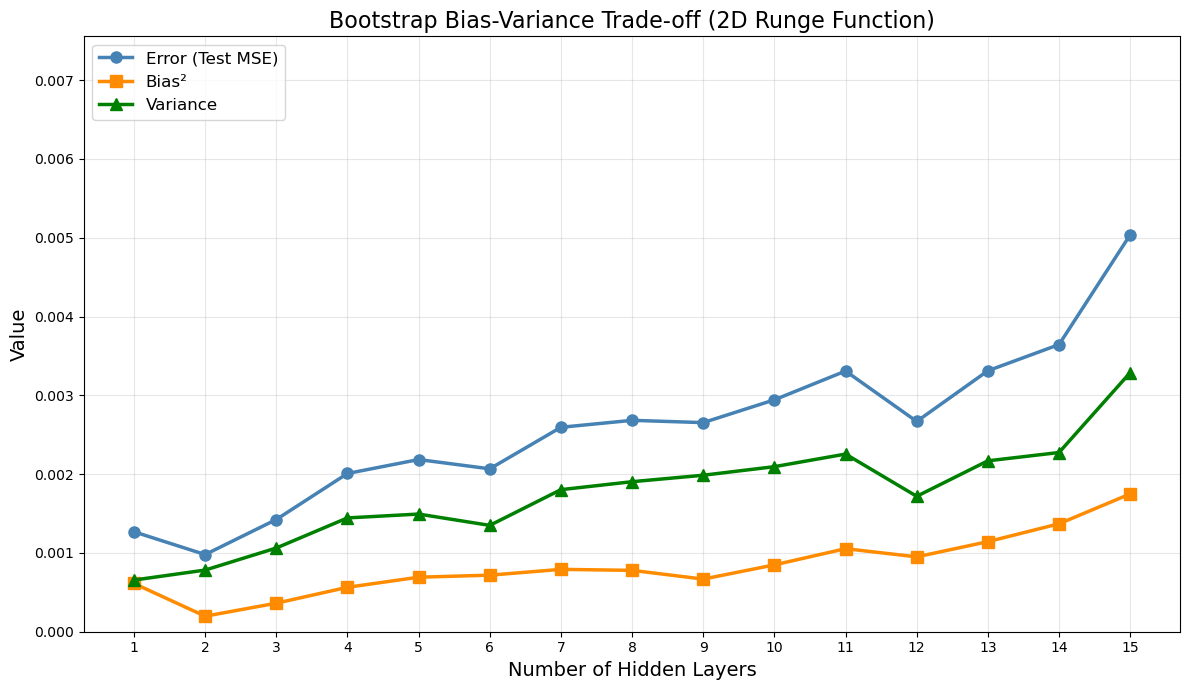

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

np.random.seed(42)

n_points = 20
x_1d = np.linspace(0, 1, n_points)
y_1d = np.linspace(0, 1, n_points)
x_mesh, y_mesh = np.meshgrid(x_1d, y_1d)

x_flat = x_mesh.ravel()
y_flat = y_mesh.ravel()
X_full = np.column_stack([x_flat, y_flat])  # Shape: (400, 2)

z_true_full = runge_function_2d(x_flat, y_flat)

X_data, X_test, z_data, z_test = train_test_split(
    X_full, z_true_full, test_size=0.3, random_state=42
)

def create_activation_functions(num_layers):
    """Leaky ReLU for first layer, Sigmoid for rest"""
    activation_funcs = []
    activation_ders = []
    
    for i in range(num_layers):
        if i == 0:
            activation_funcs.append(leaky_ReLU)
            activation_ders.append(leaky_ReLU_der)
        else:
            activation_funcs.append(sigmoid)
            activation_ders.append(sigmoid_der)
    
    return activation_funcs, activation_ders

def train_and_predict_nn(X_train, y_train, X_test, layer_sizes, epochs=500, lr=0.01,
                        l1_lambda=0.0, l2_lambda=0.0):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    targets = y_train.reshape(-1, 1)
    
    num_layers = len(layer_sizes)
    activation_funcs, activation_ders = create_activation_functions(num_layers)
    layers = create_layers_batch(2, layer_sizes)  # network_input_size = 2
    
    layers, _ = train_network_sgd_rmsprop(
        X_train_scaled, targets, layers,
        activation_funcs, activation_ders,
        lr=lr, decay_rate=0.9, eps=1e-8,
        epochs=epochs, verbose_every=None  # Add L2 regularization parameter
    )
    
    y_pred = feed_forward_batch(X_test_scaled, layers, activation_funcs)
    
    return y_pred.ravel()


n_bootstraps = 50
hidden_layer_range = range(1, 16)  

results = {
    'n_layers': [],
    'bias_squared': [],
    'variance': [],
    'error': []
}


for n_hidden in hidden_layer_range:
    print(f"\nTesting {n_hidden} hidden layer(s)...")
    
    layer_sizes = [50] * n_hidden + [1]
    
    bootstrap_predictions = np.zeros((n_bootstraps, len(z_test)))
    
    successful_bootstraps = 0
    for i in range(n_bootstraps):
        if (i + 1) % 20 == 0:
            print(f"  Bootstrap {i + 1}/{n_bootstraps}")
        

        X_bootstrap, z_bootstrap = resample(X_data, z_data, random_state=i)
        
        
        try:
            y_pred = train_and_predict_nn(
                X_bootstrap, z_bootstrap, X_test, 
                layer_sizes, epochs=500, lr=0.01
            )
            bootstrap_predictions[i, :] = y_pred
            successful_bootstraps += 1
        except Exception as e:
            bootstrap_predictions[i, :] = np.nan
    
    print(f"  Completed: {successful_bootstraps}/{n_bootstraps} successful")
    
    valid_mask = ~np.isnan(bootstrap_predictions).any(axis=1)
    bootstrap_predictions = bootstrap_predictions[valid_mask]
    


    y_pred_mean = np.mean(bootstrap_predictions, axis=0)

    bias = y_pred_mean - z_test  
    bias_squared = np.mean(bias ** 2)
    
    variance = np.mean(np.var(bootstrap_predictions, axis=0))
    
    individual_errors = np.mean((bootstrap_predictions - z_test) ** 2, axis=1)
    error = np.mean(individual_errors) 
    
    results['n_layers'].append(n_hidden)
    results['bias_squared'].append(bias_squared)
    results['variance'].append(variance)
    results['error'].append(error)
    
    print(f"  Bias²: {bias_squared:.6f}, Variance: {variance:.6f}, Error: {error:.6f}")


plt.figure(figsize=(12, 7))

plt.plot(results['n_layers'], results['error'], 'o-', linewidth=2.5, 
         markersize=8, label='Error (Test MSE)', color='steelblue')
plt.plot(results['n_layers'], results['bias_squared'], 's-', linewidth=2.5, 
         markersize=8, label='Bias²', color='darkorange')
plt.plot(results['n_layers'], results['variance'], '^-', linewidth=2.5, 
         markersize=8, label='Variance', color='green')

plt.xlabel('Number of Hidden Layers', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Bootstrap Bias-Variance Trade-off (2D Runge Function)', fontsize=16)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(results['n_layers'])

all_values = (results['error'] + results['bias_squared'] + results['variance'])
y_max = max(all_values) * 1.5  
plt.ylim(0, y_max)

plt.tight_layout()
plt.show()


Testing 10 neurons per layer...
  Bootstrap 20/50
  Bootstrap 40/50
  Completed: 50/50 successful
  Bias²: 0.000490, Variance: 0.000459, Error: 0.000948

Testing 25 neurons per layer...
  Bootstrap 20/50
  Bootstrap 40/50
  Completed: 50/50 successful
  Bias²: 0.000352, Variance: 0.000698, Error: 0.001051

Testing 50 neurons per layer...
  Bootstrap 20/50
  Bootstrap 40/50
  Completed: 50/50 successful
  Bias²: 0.000692, Variance: 0.001462, Error: 0.002154

Testing 75 neurons per layer...
  Bootstrap 20/50
  Bootstrap 40/50
  Completed: 50/50 successful
  Bias²: 0.000988, Variance: 0.002241, Error: 0.003228

Testing 100 neurons per layer...
  Bootstrap 20/50
  Bootstrap 40/50
  Completed: 50/50 successful
  Bias²: 0.000895, Variance: 0.003351, Error: 0.004246

Testing 150 neurons per layer...
  Bootstrap 20/50
  Bootstrap 40/50
  Completed: 50/50 successful
  Bias²: 0.008995, Variance: 0.006457, Error: 0.015453

Testing 200 neurons per layer...
  Bootstrap 20/50
  Bootstrap 40/50
  Co

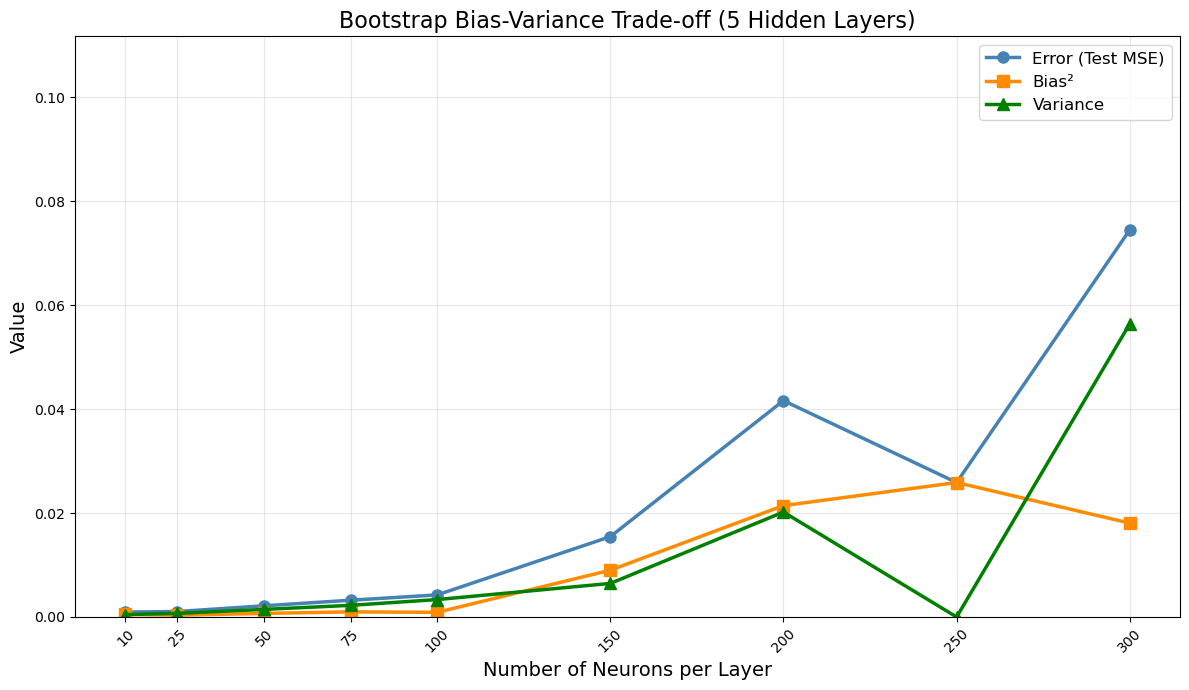

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

np.random.seed(42)

n_points = 20
x_1d = np.linspace(0, 1, n_points)
y_1d = np.linspace(0, 1, n_points)
x_mesh, y_mesh = np.meshgrid(x_1d, y_1d)

x_flat = x_mesh.ravel()
y_flat = y_mesh.ravel()
X_full = np.column_stack([x_flat, y_flat])  # Shape: (400, 2)

z_true_full = runge_function_2d(x_flat, y_flat)

X_data, X_test, z_data, z_test = train_test_split(
    X_full, z_true_full, test_size=0.3, random_state=42
)




n_bootstraps = 50
n_hidden_layers = 5


neuron_range = [10, 25, 50, 75, 100, 150, 200, 250, 300]  

results = {
    'n_neurons': [],
    'bias_squared': [],
    'variance': [],
    'error': []
}


for n_neurons in neuron_range:
    print(f"\nTesting {n_neurons} neurons per layer...")
    
    layer_sizes = [n_neurons] * n_hidden_layers + [1]
    
    bootstrap_predictions = np.zeros((n_bootstraps, len(z_test)))
    
    successful_bootstraps = 0
    for i in range(n_bootstraps):
        if (i + 1) % 20 == 0:
            print(f"  Bootstrap {i + 1}/{n_bootstraps}")
        
        X_bootstrap, z_bootstrap = resample(X_data, z_data, random_state=i)
        
        try:
            y_pred = train_and_predict_nn(
                X_bootstrap, z_bootstrap, X_test, 
                layer_sizes, epochs=500, lr=0.01
            )
            bootstrap_predictions[i, :] = y_pred
            successful_bootstraps += 1
        except Exception as e:
            bootstrap_predictions[i, :] = np.nan
    
    print(f"  Completed: {successful_bootstraps}/{n_bootstraps} successful")
    
    valid_mask = ~np.isnan(bootstrap_predictions).any(axis=1)
    bootstrap_predictions = bootstrap_predictions[valid_mask]
    
    y_pred_mean = np.mean(bootstrap_predictions, axis=0)

    bias = y_pred_mean - z_test  
    bias_squared = np.mean(bias ** 2)
    
    variance = np.mean(np.var(bootstrap_predictions, axis=0))
    
    individual_errors = np.mean((bootstrap_predictions - z_test) ** 2, axis=1)
    error = np.mean(individual_errors) 
    
    results['n_neurons'].append(n_neurons)
    results['bias_squared'].append(bias_squared)
    results['variance'].append(variance)
    results['error'].append(error)
    
    print(f"  Bias²: {bias_squared:.6f}, Variance: {variance:.6f}, Error: {error:.6f}")


# Create plot
plt.figure(figsize=(12, 7))

plt.plot(results['n_neurons'], results['error'], 'o-', linewidth=2.5, 
         markersize=8, label='Error (Test MSE)', color='steelblue')
plt.plot(results['n_neurons'], results['bias_squared'], 's-', linewidth=2.5, 
         markersize=8, label='Bias²', color='darkorange')
plt.plot(results['n_neurons'], results['variance'], '^-', linewidth=2.5, 
         markersize=8, label='Variance', color='green')


plt.xlabel('Number of Neurons per Layer', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title(f'Bootstrap Bias-Variance Trade-off ({n_hidden_layers} Hidden Layers)', fontsize=16)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, alpha=0.3)
plt.xticks(results['n_neurons'], rotation=45)

all_values = (results['error'] + results['bias_squared'] + results['variance'])
y_max = max(all_values) * 1.5  
plt.ylim(0, y_max)

plt.tight_layout()
plt.show()

Methodology: we now analyse the effects of number of hidden layers and number of neurons on the Test MSE of the network, by analyzing the bias-variance trade-off for approximiating the 2D Runge function. We run the test seperately first, and for each number of hidden layer from 1-15 with 50 neurons each, we train 50 different models on bootstrap resampled version to find the bias, variance and error. We then do the same for the number of neurons per layer, keeping the number of hidden layers constant. We will then run different combinations of hidden layers and number of neurons to produce a 2D heatmap and find the best combination.

Discussion of Results, plotting the bias, variance, and error against the number of hidden layers, we see that bias starts high and decreases while variance starts low and increases. The error exhibits a U shaped curve. This shows that underfitting occurs when the number of hidden layers is low or in this case 1, and overfitting occurs as the number of hidden layer increases. The optimal number of hidden layers in this case is 2. The same shape can be seen when increasing the number of neurons, and the optimal number of neurons is 10 neurons. The bias for both tends to increase in the later stages, which could show that there are optimization issues as the complexity of the network increases. It must be said that the optimal number of hidden layers will be dependant on the number of neurons, and vice versa. We will now try to find the optimal number of hidden layers and neurons together


## 2D heatmap for finding best combination


[1/56] Testing: 1 layers × 10 neurons
  Bias²: 0.000931, Variance: 0.000301, Error: 0.001232

[2/56] Testing: 2 layers × 10 neurons
  Bias²: 0.000685, Variance: 0.000252, Error: 0.000937

[3/56] Testing: 3 layers × 10 neurons
  Bias²: 0.000710, Variance: 0.000393, Error: 0.001103

[4/56] Testing: 4 layers × 10 neurons
  Bias²: 0.000889, Variance: 0.000674, Error: 0.001563

[5/56] Testing: 5 layers × 10 neurons
  Bias²: 0.001040, Variance: 0.000874, Error: 0.001914

[6/56] Testing: 6 layers × 10 neurons
  Bias²: 0.001400, Variance: 0.000975, Error: 0.002375

[7/56] Testing: 8 layers × 10 neurons
  Bias²: 0.001782, Variance: 0.001327, Error: 0.003110

[8/56] Testing: 10 layers × 10 neurons
  Bias²: 0.002193, Variance: 0.002290, Error: 0.004483

[9/56] Testing: 1 layers × 25 neurons
  Bias²: 0.000783, Variance: 0.000187, Error: 0.000970

[10/56] Testing: 2 layers × 25 neurons
  Bias²: 0.000501, Variance: 0.000362, Error: 0.000862

[11/56] Testing: 3 layers × 25 neurons
  Bias²: 0.000519,

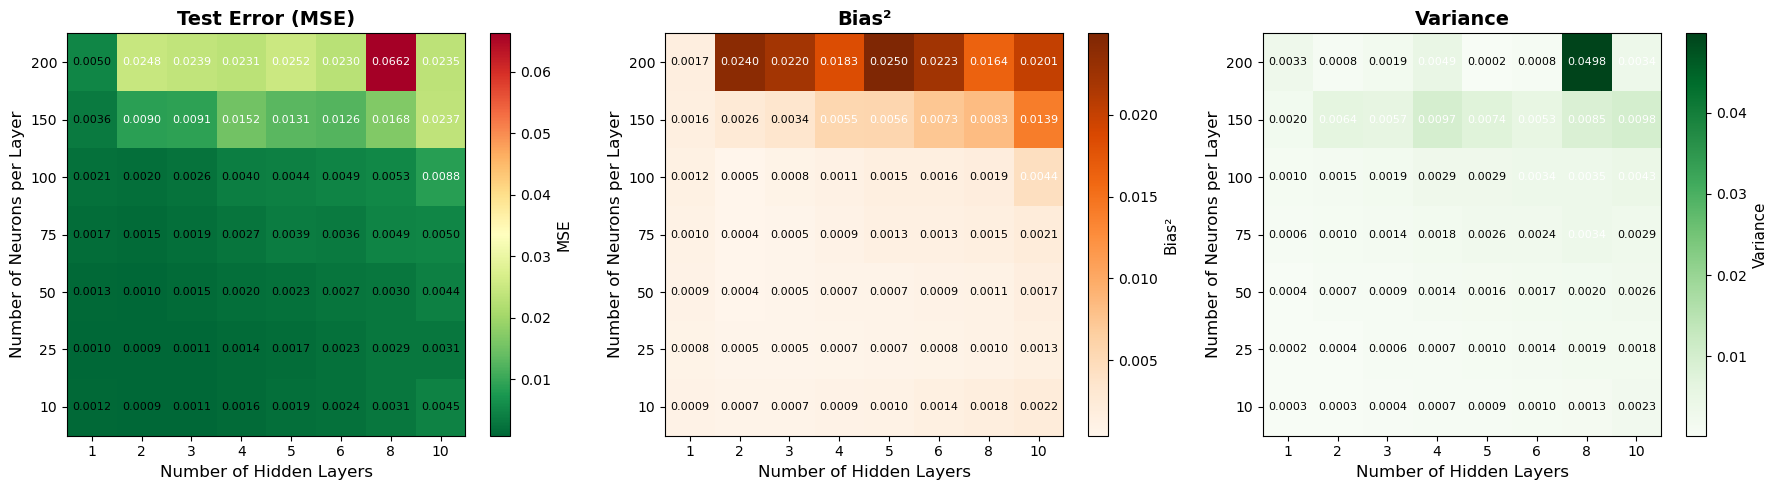

In [172]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

np.random.seed(42)

n_points = 20
x_1d = np.linspace(0, 1, n_points)
y_1d = np.linspace(0, 1, n_points)
x_mesh, y_mesh = np.meshgrid(x_1d, y_1d)

x_flat = x_mesh.ravel()
y_flat = y_mesh.ravel()
X_full = np.column_stack([x_flat, y_flat])

z_true_full = runge_function_2d(x_flat, y_flat)

X_data, X_test, z_data, z_test = train_test_split(
    X_full, z_true_full, test_size=0.3, random_state=42
)




n_bootstraps = 20


layer_range = [1, 2, 3, 4, 5, 6, 8, 10]  
neuron_range = [10, 25, 50, 75, 100, 150, 200]  


error_matrix = np.zeros((len(neuron_range), len(layer_range)))
bias_matrix = np.zeros((len(neuron_range), len(layer_range)))
variance_matrix = np.zeros((len(neuron_range), len(layer_range)))


total_iterations = len(layer_range) * len(neuron_range)
current_iteration = 0

for i, n_neurons in enumerate(neuron_range):
    for j, n_layers in enumerate(layer_range):
        current_iteration += 1
        print(f"\n[{current_iteration}/{total_iterations}] Testing: {n_layers} layers × {n_neurons} neurons")
        
        layer_sizes = [n_neurons] * n_layers + [1]
        
        bootstrap_predictions = np.zeros((n_bootstraps, len(z_test)))
        
        successful_bootstraps = 0
        for k in range(n_bootstraps):
            X_bootstrap, z_bootstrap = resample(X_data, z_data, random_state=k)
            
            try:
                y_pred = train_and_predict_nn(
                    X_bootstrap, z_bootstrap, X_test,
                    layer_sizes, epochs=500, lr=0.01
                )
                bootstrap_predictions[k, :] = y_pred
                successful_bootstraps += 1
            except Exception as e:
                bootstrap_predictions[k, :] = np.nan
        
        # Remove failed bootstraps
        valid_mask = ~np.isnan(bootstrap_predictions).any(axis=1)
        bootstrap_predictions = bootstrap_predictions[valid_mask]
        

        
        y_pred_mean = np.mean(bootstrap_predictions, axis=0)
        bias = y_pred_mean - z_test
        bias_squared = np.mean(bias ** 2)
        variance = np.mean(np.var(bootstrap_predictions, axis=0))
        individual_errors = np.mean((bootstrap_predictions - z_test) ** 2, axis=1)
        error = np.mean(individual_errors)
        
        error_matrix[i, j] = error
        bias_matrix[i, j] = bias_squared
        variance_matrix[i, j] = variance
        
        print(f"  Bias²: {bias_squared:.6f}, Variance: {variance:.6f}, Error: {error:.6f}")





fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ax1 = axes[0]
im1 = ax1.imshow(error_matrix, cmap='RdYlGn_r', aspect='auto', origin='lower')
ax1.set_xlabel('Number of Hidden Layers', fontsize=12)
ax1.set_ylabel('Number of Neurons per Layer', fontsize=12)
ax1.set_title('Test Error (MSE)', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(layer_range)))
ax1.set_xticklabels(layer_range)
ax1.set_yticks(range(len(neuron_range)))
ax1.set_yticklabels(neuron_range)

cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label('MSE', fontsize=11)

for i in range(len(neuron_range)):
    for j in range(len(layer_range)):
        if not np.isnan(error_matrix[i, j]):
            text = ax1.text(j, i, f'{error_matrix[i, j]:.4f}',
                           ha='center', va='center', fontsize=8,
                           color='white' if error_matrix[i, j] > np.nanmean(error_matrix) else 'black')

ax2 = axes[1]
im2 = ax2.imshow(bias_matrix, cmap='Oranges', aspect='auto', origin='lower')
ax2.set_xlabel('Number of Hidden Layers', fontsize=12)
ax2.set_ylabel('Number of Neurons per Layer', fontsize=12)
ax2.set_title('Bias²', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(layer_range)))
ax2.set_xticklabels(layer_range)
ax2.set_yticks(range(len(neuron_range)))
ax2.set_yticklabels(neuron_range)

cbar2 = plt.colorbar(im2, ax=ax2)
cbar2.set_label('Bias²', fontsize=11)

for i in range(len(neuron_range)):
    for j in range(len(layer_range)):
        if not np.isnan(bias_matrix[i, j]):
            text = ax2.text(j, i, f'{bias_matrix[i, j]:.4f}',
                           ha='center', va='center', fontsize=8,
                           color='white' if bias_matrix[i, j] > np.nanmean(bias_matrix) else 'black')

ax3 = axes[2]
im3 = ax3.imshow(variance_matrix, cmap='Greens', aspect='auto', origin='lower')
ax3.set_xlabel('Number of Hidden Layers', fontsize=12)
ax3.set_ylabel('Number of Neurons per Layer', fontsize=12)
ax3.set_title('Variance', fontsize=14, fontweight='bold')
ax3.set_xticks(range(len(layer_range)))
ax3.set_xticklabels(layer_range)
ax3.set_yticks(range(len(neuron_range)))
ax3.set_yticklabels(neuron_range)

cbar3 = plt.colorbar(im3, ax=ax3)
cbar3.set_label('Variance', fontsize=11)

for i in range(len(neuron_range)):
    for j in range(len(layer_range)):
        if not np.isnan(variance_matrix[i, j]):
            text = ax3.text(j, i, f'{variance_matrix[i, j]:.4f}',
                           ha='center', va='center', fontsize=8,
                           color='white' if variance_matrix[i, j] > np.nanmean(variance_matrix) else 'black')

plt.tight_layout()
plt.show()

The best combination is with 2 hidden layers with either 10/25 neurons. The results are similar to before, where we achieve a steady decrease in bias at first, and it increases as the complexity of the neural network gets too large, while variance increases steadily as the complexity of the network increases. 

# Part E

## Finding Benchmark MSE for Ridge and Lasso

In [175]:
def ridge_reg(X, y, lam):
    n_features = X.shape[1]
    I = np.eye(n_features)
    beta = np.linalg.pinv(X.T @ X + lam * I) @ X.T @ y
    return beta

np.random.seed(42)
n_points = 100
x = np.linspace(-1, 1, n_points).reshape(-1, 1)
d = 9
lam = 0.01

y_true = runge_function(x).ravel()


# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

X_train = design_matrix_ols(x_train_scaled, d)
X_test = design_matrix_ols(x_test_scaled, d)
        
beta = ridge_reg(X_train, y_train, lam)
y_train_pred = predict_ols(X_train, beta)
y_test_pred = predict_ols(X_test, beta)


print(mse(y_test, y_test_pred))



0.003841851350151335


In [218]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
n_points = 100
x = np.linspace(-1, 1, n_points).reshape(-1, 1)
d = 9
lam = 0.01

y_true = runge_function(x).ravel()
y = y_true

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

def soft_threshold(z, t):
    """Element-wise soft-threshold"""
    return np.sign(z) * np.maximum(np.abs(z) - t, 0.0)

def standardize_design_matrix_cols_1p(X):
    """Standardize columns 1..p-1 (leave intercept) for L1 stability."""
    Xs = X.copy()
    if Xs.shape[1] > 1:
        mu = Xs[:, 1:].mean(axis=0)
        sd = Xs[:, 1:].std(axis=0) + 1e-12
        Xs[:, 1:] = (Xs[:, 1:] - mu) / sd
    return Xs

def lasso_ista(X, y, lam, max_iters=10000, tol=1e-8, theta0=None, standardize_cols=True):
    """
    Solve:  C(θ) = (1/n)||y - Xθ||^2 + λ||θ||_1  (no penalty on θ0)
    """
    n, p = X.shape
    
    Xs = standardize_design_matrix_cols_1p(X) if standardize_cols else X
    theta = np.zeros(p) if theta0 is None else theta0.copy()
    
    # Lipschitz constant of the smooth part
    L = (2.0 / n) * np.linalg.eigvalsh(Xs.T @ Xs).max()
    t = 1.0 / (L + 1e-18)
    
    history = {"obj": []}
    
    def obj(theta):
        r = y - Xs @ theta
        return (r @ r) / n + lam * np.sum(np.abs(theta[1:]))
    
    prev = obj(theta)
    history["obj"].append(prev)
    
    for _ in range(max_iters):
        g = (2.0 / n) * (Xs.T @ (Xs @ theta - y))
        z = theta - t * g
        
        z0 = z[0]
        z_rest = soft_threshold(z[1:], lam * t)
        
        theta_new = np.empty_like(theta)
        theta_new[0] = z0
        theta_new[1:] = z_rest
        
        cur = obj(theta_new)
        history["obj"].append(cur)
        
        if abs(prev - cur) < tol:
            theta = theta_new
            break
        
        theta, prev = theta_new, cur
    
    return theta, history, Xs

def standardize_train_test(Xtr, Xte):
    """Standardize train and test design matrices consistently"""
    Xtr_ = Xtr.copy()
    Xte_ = Xte.copy()
    
    if Xtr_.shape[1] > 1:
        mu = Xtr_[:, 1:].mean(axis=0)
        sd = Xtr_[:, 1:].std(axis=0) + 1e-12
        Xtr_[:, 1:] = (Xtr_[:, 1:] - mu) / sd
        Xte_[:, 1:] = (Xte_[:, 1:] - mu) / sd
    
    return Xtr_, Xte_

def lasso_grid_search(degrees, lambdas):
    """Find best MSE across degrees and lambdas"""
    best_mse_ista = float('inf')
    best_params_ista = {}
    
    best_mse_skl = float('inf')
    best_params_skl = {}
    
    for i, d in enumerate(degrees):
        print(f"Processing degree {d}/{degrees[-1]}...")
        
        # Build design matrices
        Xtr = design_matrix_ols(x_train_scaled, d)
        Xte = design_matrix_ols(x_test_scaled, d)
        Xtr_s, Xte_s = standardize_train_test(Xtr, Xte)
        
        for j, lam in enumerate(lambdas):
            # --- ISTA ---
            theta, _, _ = lasso_ista(Xtr_s, y_train, lam=lam, max_iters=4000, 
                                     tol=1e-8, standardize_cols=False)
            yhat_te = Xte_s @ theta
            mse_ista = mse(y_test, yhat_te)
            
            if mse_ista < best_mse_ista:
                best_mse_ista = mse_ista
                best_params_ista = {'degree': d, 'lambda': lam, 'theta': theta}
            
            # --- Scikit-learn ---
            alpha = lam / 2.0
            clf = Lasso(alpha=alpha, fit_intercept=False, max_iter=100000, tol=1e-8)
            clf.fit(Xtr_s, y_train)
            yhat_te_skl = clf.predict(Xte_s)
            mse_skl = mse(y_test, yhat_te_skl)
            
            if mse_skl < best_mse_skl:
                best_mse_skl = mse_skl
                best_params_skl = {'degree': d, 'lambda': lam, 'coef': clf.coef_}
    
    return {
        'ista': {'best_mse': best_mse_ista, 'params': best_params_ista},
        'skl': {'best_mse': best_mse_skl, 'params': best_params_skl}
    }


degrees = np.arange(1, 16)        
lambdas = np.logspace(-4, 1, 30)     



results = lasso_grid_search(degrees, lambdas)



print("\n*** ISTA (Custom Implementation) ***")
print(f"Best Test MSE: {results['ista']['best_mse']:.8f}")
print(f"Optimal Degree: {results['ista']['params']['degree']}")
print(f"Optimal Lambda: {results['ista']['params']['lambda']:.6f}")
print(f"Number of non-zero coefficients: {np.sum(np.abs(results['ista']['params']['theta']) > 1e-6)}")

print("\n*** Scikit-learn LASSO ***")
print(f"Best Test MSE: {results['skl']['best_mse']:.8f}")
print(f"Optimal Degree: {results['skl']['params']['degree']}")
print(f"Optimal Lambda: {results['skl']['params']['lambda']:.6f}")
print(f"Number of non-zero coefficients: {np.sum(np.abs(results['skl']['params']['coef']) > 1e-6)}")



Processing degree 1/15...
Processing degree 2/15...
Processing degree 3/15...
Processing degree 4/15...
Processing degree 5/15...
Processing degree 6/15...
Processing degree 7/15...
Processing degree 8/15...


/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.277e-06, tolerance: 1.156e-07
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.047e-06, tolerance: 1.156e-07
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Processing degree 9/15...


/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.370e-06, tolerance: 1.156e-07
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.152e-06, tolerance: 1.156e-07
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Processing degree 10/15...


/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.512e-03, tolerance: 1.156e-07
  model = cd_fast.enet_coordinate_descent(


Processing degree 11/15...


/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.061e-03, tolerance: 1.156e-07
  model = cd_fast.enet_coordinate_descent(


Processing degree 12/15...


/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.216e-03, tolerance: 1.156e-07
  model = cd_fast.enet_coordinate_descent(


Processing degree 13/15...


/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.228e-03, tolerance: 1.156e-07
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.702e-05, tolerance: 1.156e-07
  model = cd_fast.enet_coordinate_descent(


Processing degree 14/15...


/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.204e-03, tolerance: 1.156e-07
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.014e-04, tolerance: 1.156e-07
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Processing degree 15/15...


/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.267e-03, tolerance: 1.156e-07
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.066e-04, tolerance: 1.156e-07
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre


*** ISTA (Custom Implementation) ***
Best Test MSE: 0.00239576
Optimal Degree: 6
Optimal Lambda: 0.000329
Number of non-zero coefficients: 7

*** Scikit-learn LASSO ***
Best Test MSE: 0.00112320
Optimal Degree: 15
Optimal Lambda: 0.000100
Number of non-zero coefficients: 11


## Defining new functions for regularization and testing

In [219]:
def train_network_sgd_rmsprop_regularization(
    inputs, targets, layers, activation_funcs, activation_ders,
    lr=0.001, decay_rate=0.9, eps=1e-8, epochs=300, verbose_every=25, 
    loss_func=None, l1_lambda=0.0, l2_lambda=0.0
):

    if loss_func is None:
        loss_func = mse
    
    cache = [(np.zeros_like(W), np.zeros_like(b)) for (W, b) in layers]
    loss_hist = []
    
    for ep in range(epochs):
        preds = feed_forward_batch(inputs, layers, activation_funcs)
        
        base_loss = loss_func(preds, targets)
        
        l1_penalty = 0.0
        l2_penalty = 0.0
        if l1_lambda > 0 or l2_lambda > 0:
            for W, b in layers:
                if l1_lambda > 0:
                    l1_penalty += np.sum(np.abs(W))
                if l2_lambda > 0:
                    l2_penalty += np.sum(W ** 2)
        
        total_loss = base_loss + l1_lambda * l1_penalty + l2_lambda * l2_penalty
        loss_hist.append(total_loss)
        
        grads = backpropagation_batch(inputs, layers, activation_funcs, targets, activation_ders)
        
        new_layers = []
        for (W, b), (dW, db), (cW, cb) in zip(layers, grads, cache):
            dW_reg = dW.copy()
            if l1_lambda > 0:
                dW_reg += l1_lambda * np.sign(W)  
            if l2_lambda > 0:
                dW_reg += 2 * l2_lambda * W       
            
            cW = decay_rate * cW + (1 - decay_rate) * (dW_reg ** 2)
            cb = decay_rate * cb + (1 - decay_rate) * (db ** 2)
            
            W = W - lr * dW_reg / (np.sqrt(cW) + eps)
            b = b - lr * db / (np.sqrt(cb) + eps)
            
            new_layers.append((W, b))
            cache[len(new_layers)-1] = (cW, cb)
        layers = new_layers
        
        if verbose_every and (ep % verbose_every == 0 or ep == epochs-1):
            reg_str = ""
            if l1_lambda > 0 or l2_lambda > 0:
                reg_str = f" | L1: {l1_penalty:.4f} | L2: {l2_penalty:.4f}"
            print(f"epoch {ep:4d} | loss {total_loss:.4f} (base: {base_loss:.4f}){reg_str}")
    
    return layers, loss_hist


Testing L2 lambda = 0.0
  Test MSE: 0.003110

Testing L2 lambda = 0.0001
  Test MSE: 0.002772

Testing L2 lambda = 0.0005
  Test MSE: 0.003471

Testing L2 lambda = 0.001
  Test MSE: 0.004428

Testing L2 lambda = 0.005
  Test MSE: 0.009733

Testing L2 lambda = 0.01
  Test MSE: 0.017085

Testing L2 lambda = 0.05
  Test MSE: 0.025950

Testing L2 lambda = 0.1
  Test MSE: 0.044055

Testing L2 lambda = 0.5
  Test MSE: 0.012192

Testing L2 lambda = 1.0
  Test MSE: 0.034969


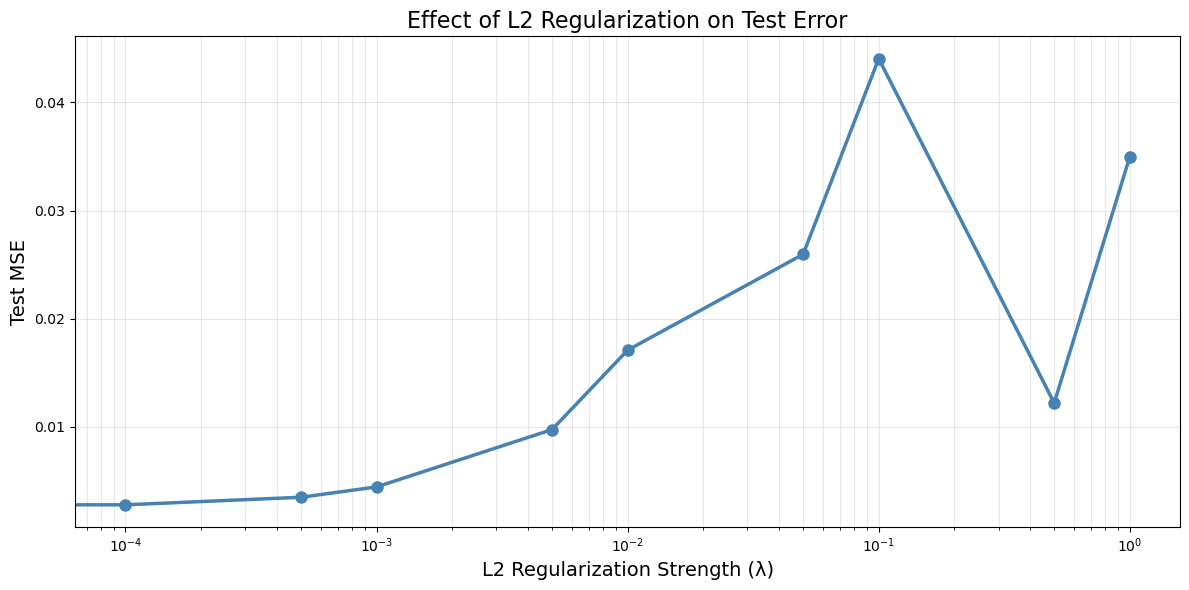

In [208]:
import numpy as np

np.random.seed(42)

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
targets = y_train.reshape(-1, 1)
inputs = x_train_scaled
network_input_size = 1
layer_output_sizes = [25, 25, 1]
activation_funcs = [leaky_ReLU, sigmoid, sigmoid]
activation_ders = [leaky_ReLU_der, sigmoid_der, sigmoid_der]

# Test different L2 lambda values
l2_lambdas = [0.0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
test_mses = []



for idx, l2_lambda in enumerate(l2_lambdas):
    print(f"\nTesting L2 lambda = {l2_lambda}")
    
    np.random.seed(42 + idx)
    
    layers = create_layers_batch(network_input_size, layer_output_sizes)
    
    layers, _ = train_network_sgd_rmsprop_regularization(
        inputs, targets, layers,
        activation_funcs, activation_ders,
        lr=0.001, decay_rate=0.9, eps=1e-8,
        epochs=epochs, verbose_every=None,
        l1_lambda=0.0,      # No L1
        l2_lambda=l2_lambda  # Current L2 strength
    )
    
    y_pred_test = feed_forward_batch(x_test_scaled, layers, activation_funcs)
    test_mse = mse(y_test.reshape(-1, 1), y_pred_test)
    test_mses.append(test_mse)
    
    print(f"  Test MSE: {test_mse:.6f}")





plt.figure(figsize=(12, 6))

plt.plot(l2_lambdas, test_mses, 'o-', linewidth=2.5, markersize=8, color='steelblue')

plt.xlabel('L2 Regularization Strength (λ)', fontsize=14)
plt.ylabel('Test MSE', fontsize=14)
plt.title('Effect of L2 Regularization on Test Error', fontsize=16)
plt.xscale('log')  # Log scale for x-axis since lambdas span multiple orders of magnitude
plt.grid(True, alpha=0.3, which='both')



plt.tight_layout()
plt.show()


Testing L1 lambda = 0.0
  Test MSE: 0.003110

Testing L1 lambda = 0.0001
  Test MSE: 0.002671

Testing L1 lambda = 0.0005
  Test MSE: 0.003463

Testing L1 lambda = 0.001
  Test MSE: 0.004825

Testing L1 lambda = 0.005
  Test MSE: 0.011958

Testing L1 lambda = 0.01
  Test MSE: 0.015420

Testing L1 lambda = 0.05
  Test MSE: 0.032018

Testing L1 lambda = 0.1
  Test MSE: 0.052696

Testing L1 lambda = 0.5
  Test MSE: 0.012484

Testing L1 lambda = 1.0
  Test MSE: 0.035261


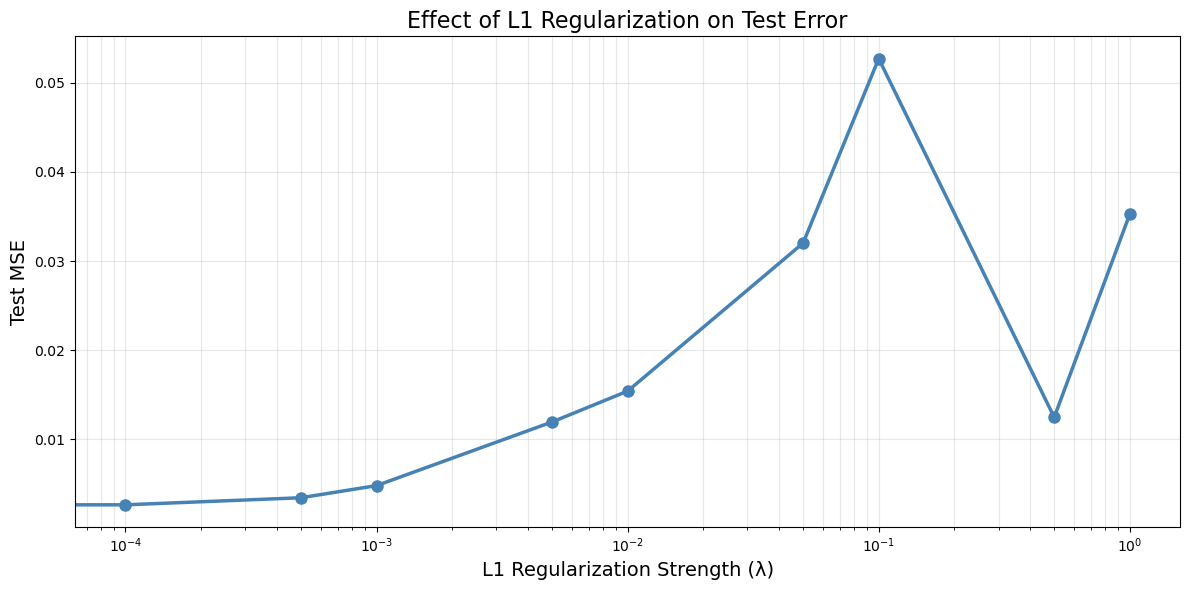

In [212]:
import numpy as np

np.random.seed(42)

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
targets = y_train.reshape(-1, 1)
inputs = x_train_scaled
network_input_size = 1
layer_output_sizes = [25, 25, 1]
activation_funcs = [leaky_ReLU, sigmoid, sigmoid]
activation_ders = [leaky_ReLU_der, sigmoid_der, sigmoid_der]

# Test different L2 lambda values
l1_lambdas = [0.0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
test_mses = []



for idx, l1_lambda in enumerate(l1_lambdas):
    print(f"\nTesting L1 lambda = {l1_lambda}")
    
    np.random.seed(42 + idx)
    
    layers = create_layers_batch(network_input_size, layer_output_sizes)
    
    layers, _ = train_network_sgd_rmsprop_regularization(
        inputs, targets, layers,
        activation_funcs, activation_ders,
        lr=0.001, decay_rate=0.9, eps=1e-8,
        epochs=epochs, verbose_every=None,
        l1_lambda=l1_lambda,      # No L1
        l2_lambda=0  # Current L2 strength
    )
    
    y_pred_test = feed_forward_batch(x_test_scaled, layers, activation_funcs)
    test_mse = mse(y_test.reshape(-1, 1), y_pred_test)
    test_mses.append(test_mse)
    
    print(f"  Test MSE: {test_mse:.6f}")





plt.figure(figsize=(12, 6))

plt.plot(l1_lambdas, test_mses, 'o-', linewidth=2.5, markersize=8, color='steelblue')

plt.xlabel('L1 Regularization Strength (λ)', fontsize=14)
plt.ylabel('Test MSE', fontsize=14)
plt.title('Effect of L1 Regularization on Test Error', fontsize=16)
plt.xscale('log')  # Log scale for x-axis since lambdas span multiple orders of magnitude
plt.grid(True, alpha=0.3, which='both')



plt.tight_layout()
plt.show()

# Part F

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

def softmax(z):
    """Softmax activation function for multi-class classification"""
    # Subtract max for numerical stability
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

def softmax_der(z):
    """Derivative of softmax - will be handled in cross-entropy derivative"""
    # For softmax, the derivative is computed differently in backpropagation
    # We'll handle this in the cross_entropy_der_batch function
    s = softmax(z)
    return s * (1 - s)  # This is simplified, actual derivative is more complex

def cross_entropy(y_pred, y_true):
    """Cross-entropy loss for multi-class classification"""
    # y_pred: predicted probabilities (batch_size, num_classes)
    # y_true: true labels (batch_size, num_classes) in one-hot encoding
    n = y_pred.shape[0]
    # Add small epsilon to avoid log(0)
    epsilon = 1e-12
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    
    # For one-hot encoded labels
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:
        return -np.sum(y_true * np.log(y_pred)) / n
    else:
        # For integer labels
        return -np.sum(np.log(y_pred[np.arange(n), y_true.astype(int)])) / n

def cross_entropy_der_batch(y_pred, y_true):
    """Derivative of cross-entropy loss with softmax"""
    # This combines the derivative of cross-entropy and softmax
    n = y_pred.shape[0]
    
    # If y_true is one-hot encoded
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:
        return (y_pred - y_true) / n
    else:
        # If y_true is integer labels, convert to one-hot
        y_true_int = y_true.astype(int)
        y_true_one_hot = np.eye(y_pred.shape[1])[y_true_int]
        return (y_pred - y_true_one_hot) / n

def one_hot_encode(y, num_classes=10):
    """Convert integer labels to one-hot encoding"""
    n = y.shape[0]
    y_one_hot = np.zeros((n, num_classes))
    y_one_hot[np.arange(n), y.astype(int)] = 1
    return y_one_hot

def backpropagation_batch_classification(inputs, layers, activation_funcs, targets, activation_ders, 
                                         cost_der=cross_entropy_der_batch):
    N = inputs.shape[0]
    layer_inputs, zs, predict = feed_forward_saver_batch(inputs, layers, activation_funcs)

    layer_grads = [None] * len(layers)
    dC_dz_next = None  

    for i in reversed(range(len(layers))):
        layer_input = layer_inputs[i]      
        z = zs[i]                        
        activation_der = activation_ders[i]

        if i == len(layers) - 1:
            dC_da = cost_der(predict, targets)               
            dC_dz = dC_da
        else:
            W_next, _ = layers[i + 1]                        
            dC_da = dC_dz_next @ W_next                      
            dC_dz = dC_da * activation_der(z).T                  

        dC_dW = dC_dz.T @ layer_input                    
        dC_db = np.sum(dC_dz.T, axis=1, keepdims=True)   

        layer_grads[i] = (dC_dW, dC_db)
        dC_dz_next = dC_dz                                

    return layer_grads

def train_network_mnist(inputs, targets, layers, activation_funcs, activation_ders, lr=0.5, beta1=0.9, beta2=0.999, 
                        eps=1e-8, epochs=100, verbose_every=10, num_classes=10):
    if len(targets.shape) == 1 or targets.shape[1] == 1:
        targets_one_hot = one_hot_encode(targets, num_classes)
    else:
        targets_one_hot = targets
    
    m = [(np.zeros_like(W), np.zeros_like(b)) for (W, b) in layers]
    v = [(np.zeros_like(W), np.zeros_like(b)) for (W, b) in layers]
    
    loss_hist = []
    accuracy_hist = []
    
    for ep in range(epochs):
        preds = feed_forward_batch(inputs, layers, activation_funcs)
        
        loss = cross_entropy(preds, targets_one_hot)
        predicted_classes = np.argmax(preds, axis=1)
        true_classes = np.argmax(targets_one_hot, axis=1) if len(targets_one_hot.shape) > 1 else targets.astype(int)
        accuracy = np.mean(predicted_classes == true_classes)
        
        loss_hist.append(loss)
        accuracy_hist.append(accuracy)
        
        grads = backpropagation_batch_classification(
            inputs, layers, activation_funcs, targets_one_hot, activation_ders
        )
        
        new_layers = []
        t = ep + 1
        
        for i, ((W, b), (dW, db), (mW, mb), (vW, vb)) in enumerate(zip(layers, grads, m, v)):
            mW = beta1 * mW + (1 - beta1) * dW
            mb = beta1 * mb + (1 - beta1) * db
            
            vW = beta2 * vW + (1 - beta2) * (dW ** 2)
            vb = beta2 * vb + (1 - beta2) * (db ** 2)
            
            mW_hat = mW / (1 - beta1 ** t)
            mb_hat = mb / (1 - beta1 ** t)
            vW_hat = vW / (1 - beta2 ** t)
            vb_hat = vb / (1 - beta2 ** t)
            
            W = W - lr * mW_hat / (np.sqrt(vW_hat) + eps)
            b = b - lr * mb_hat / (np.sqrt(vb_hat) + eps)
            
            new_layers.append((W, b))
            m[i] = (mW, mb)
            v[i] = (vW, vb)
        
        layers = new_layers
        
        if verbose_every and (ep % verbose_every == 0 or ep == epochs-1):
            print(f"Epoch {ep:4d} | Loss: {loss:.4f} | Accuracy: {accuracy:.4f}")
    
    return layers, loss_hist, accuracy_hist

def leaky_ReLU(z, alpha=0.01):
    """Leaky ReLU activation function"""
    return np.where(z > 0, z, alpha * z)

def leaky_ReLU_der(z, alpha=0.01):
    """Derivative of Leaky ReLU"""
    return np.where(z > 0, 1, alpha)

def create_layers_batch(network_input_size, layer_output_sizes):
    layers = []

    i_size = network_input_size
    for layer_output_size in layer_output_sizes:
        W = np.random.randn(layer_output_size, i_size)
        b = np.full((layer_output_size, 1), 0.01)
        layers.append((W, b))

        i_size = layer_output_size
    return layers

def feed_forward_batch(inputs, layers, activation_funcs):
    a = inputs
    for (W, b), activation_func in zip(layers, activation_funcs):
        z = W @ a.T + b
        a = activation_func(z).T
    return a

def feed_forward_saver_batch(inputs, layers, activation_funcs):
    layer_inputs = []   
    zs = []             
    a = inputs

    for (W, b), activation_func in zip(layers, activation_funcs):
        layer_inputs.append(a)
        z = W @ a.T + b                  
        a = activation_func(z).T        
        zs.append(z)
    return layer_inputs, zs, a

def main():
    """Main function to train and evaluate MNIST classifier"""
    # Fetch the MNIST dataset
    print("Loading MNIST dataset...")
    mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')

    # Extract data (features) and target (labels)
    X = mnist.data
    y = mnist.target

    X = X / 255.0

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Use smaller training set for faster training
    train_size = 10000  
    X_train_small = X_train_flat[:train_size]
    y_train_small = y_train[:train_size].astype(int)

    X_train_norm = X_train_small / 255.0
    X_test_norm = X_test_flat / 255.0

    # Network architecture
    network_input_size = 784  
    layer_output_sizes = [128, 64, 10]  
    activation_funcs = [leaky_ReLU, leaky_ReLU, softmax]  
    activation_ders = [leaky_ReLU_der, leaky_ReLU_der, softmax_der]

    print(f"Training network architecture: {[network_input_size] + layer_output_sizes}")

    # Initialize layers
    np.random.seed(42)
    layers = create_layers_batch(network_input_size, layer_output_sizes)

    # Train the network
    trained_layers, loss_history, accuracy_history = train_network_mnist(
        X_train_norm, y_train_small, layers, activation_funcs, activation_ders,
        lr=0.001, epochs=50, verbose_every=5
    )

    # Evaluate on test set
    print("\nEvaluating on test set...")
    test_preds = feed_forward_batch(X_test_norm, trained_layers, activation_funcs)
    test_pred_classes = np.argmax(test_preds, axis=1)
    test_accuracy = np.mean(test_pred_classes == y_test.astype(int))

    print(f"Final Test Accuracy: {test_accuracy:.4f}")

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(loss_history)
    plt.title('Training Loss (Cross-Entropy)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(accuracy_history)
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    
    return trained_layers, loss_history, accuracy_history, test_accuracy
